In [69]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "True"
from external.Nonlincausality.nonlincausality import nonlincausality
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import pprint
import numpy as np
#from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
import seaborn as sns
import json
import warnings
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import f_regression, mutual_info_regression
from itertools import combinations
from functions_analysis import *
import statsmodels.api as sm
from scipy.stats import f
# Suppress the specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
import locale
locale.setlocale(locale.LC_COLLATE, 'pl_PL.UTF-8')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tempfile
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pickle

from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore')

In [35]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', 800)

# Dataset preparation

In [36]:
column_labels_pl = {
    # Stock columns
    'Otwarcie': 'Otwarcie',
    'Najwyzszy': 'Najwyższy kurs',
    'Najnizszy': 'Najniższy kurs',
    'Zamkniecie': 'Zamknięcie',
    'Wolumen': 'Wolumen',
    'Return': 'Zwrot',
    'volatility': 'Zmienność',
    'Direction': 'Kierunek',
    'Change': 'Zmiana (%)',

    # Tweet columns
    'Negative': 'Neg. tweety',
    'Neutral': 'Neu. tweety',
    'Positive': 'Poz. tweety',
    'view_count_Negative': 'Wyświetl. - neg.',
    'view_count_Neutral': 'Wyświetl. - neu.',
    'view_count_Positive': 'Wyświetl. - poz.',
    'total_retweet_count': 'Łączna liczba retweetów',
    'retweet_count_Negative': 'Retweety - neg.',
    'retweet_count_Neutral': 'Retweety - neu.',
    'retweet_count_Positive': 'Retweety - poz.',
    'tweet_volume': 'Liczba tweetów',
    'sentiment_score': 'Sent.',
    'sentiment_score_views': 'Sent. (waż. wyśw.)',
    'total_views': 'Łączna liczba wyświetl.',
    'sentiment_polarity': 'Polaryzacja sent.',
    'view_weighted_polarity': 'Polaryzacja (waż. wyśw.)',
    'sentiment_intensity': 'Intensywność sent.',
    'amplified_sentiment': 'Wzmocniony sent.',
    'sentiment_divergence': 'Rozbież. sent.',
    'engagement_impact': 'Wpływ zaangażowania',
}

In [37]:
# path = r'E:\Project_clean\PolishTweetsClassification\trained\1074368204844310350\checkpoint-808'
# model = AutoModelForSequenceClassification.from_pretrained(path)
# tokenizer = AutoTokenizer.from_pretrained("sdadas/polish-roberta-base-v2")

In [38]:
# df_processed = pd.read_csv('TrainingData/FINAL_TWEET_DATA_CLEANED.csv')
# df_processed['Date'] = pd.to_datetime(df_processed['created_at'], errors='coerce')
# df_processed =df_processed[~df_processed['text'].isna()]
# df_processed['sentiment_analysis'] = df_processed['text'].apply(lambda x: analyze_sentiment(text=x,tokenizer=tokenizer,model=model))
# df_processed[['sentiment', 'confidence']] = pd.DataFrame(df_processed['sentiment_analysis'].tolist())
# df_processed.to_csv('dataset2_analyzed.csv')
# df_processed.to_csv('dataset2_analyzed.csv')


In [39]:
# 1. Load the dataset
dataset_analyzed = pd.read_csv('dataset2_analyzed.csv')

# 2. Drop unwanted columns
columns = [col for col in dataset_analyzed.columns if col not in ['Unnamed: 0', 'Unnamed: 0.1']]
dataset_analyzed = dataset_analyzed[columns]

# 4. Parse 'created_at' as UTC datetime (handles tz-aware and tz-naive values safely)
dataset_analyzed['created_at'] = pd.to_datetime(dataset_analyzed['created_at'], errors='raise', utc=True)

# 5. Convert to Warsaw time
dataset_analyzed['created_at'] = dataset_analyzed['created_at'].dt.tz_convert('Europe/Warsaw')

# 6. Create 'Date' column (date only, no time, tz-naive)
dataset_analyzed['Date'] = dataset_analyzed['created_at'].dt.normalize().dt.tz_localize(None)

dates_to_remove = [
    pd.Timestamp('2022-12-31 00:00:00'),
    pd.Timestamp('2024-01-01 00:00:00')
]

dataset_analyzed = dataset_analyzed[~dataset_analyzed['Date'].isin(dates_to_remove)]


In [40]:
dataset_analyzed.loc[:,'company'] = dataset_analyzed['company'].apply(lambda x: x.upper())

In [41]:
dataset_analyzed = dataset_analyzed[~((dataset_analyzed['Date']<pd.Timestamp('2024-07-02 00:00:00')) & (dataset_analyzed['company']=='MENTZEN'))]
dataset_analyzed = dataset_analyzed[~((dataset_analyzed['Date']<pd.Timestamp('2024-10-17 00:00:00')) & (dataset_analyzed['company']=='ŻABKA'))]

In [42]:
dataset_analyzed[dataset_analyzed['company']=='ŻABKA'].sort_values(by='created_at', ascending=True)

id                created_at                        user_name              user_id                                                                                                                                                                                                                                                 text lang   in_reply_to  is_quote_status      quote_id  retweeted_tweet_id  possibly_sensitive  quote_count  reply_count  favorite_count  retweet_count  view_count       hashtags urls  is_translatable  has_card thumbnail_title thumbnail_url company                   timestamp            agent stock_company       Date                sentiment_analysis sentiment  confidence
53795  1846970325801509233 2024-10-17 00:00:00+02:00                           Michał  1824704480614445056                                                             @Radoslaw2202 hehe wtedy by się okazało że jednak te multikulti nie jest trakie fajne :D choć... choć...  może być inny fikołek, że okaże się to był rodowity polak jak ten pod żabką! 🤡   pl  1.846589e+18                0           NaN                 NaN                 NaN            0            0               0              0        98.0            NaN  NaN              0.0         0             NaN           NaN   ŻABKA  2024-11-12 18:25:08.407289     @heniek36988         ZABKA 2024-10-17   ('Neutral', 0.8284210562705994)   Neutral    0.828421
53898  1846865778844237969 2024-10-17 00:00:00+02:00                 Maksymilian Kuch  1790327975491088384                                   #ZAB lekko odbija przy RSI zbliżającym się do poziomu wyprzedania. Jeśli jednak kurs pozostanie dłużej poniżej 23,6% zniesienia Fibonacciego, może to oznaczać słabość popytu. #Zabka #IPO https://t.co/dk6XHKkvLZ   pl           NaN                0           NaN                 NaN                 0.0            4           25               9              1     34118.0  ZAB,Zabka,IPO  NaN              0.0         0             NaN           NaN   ŻABKA  2024-11-12 18:30:05.259231     @heniek36988         ZABKA 2024-10-17  ('Negative', 0.7082975506782532)  Negative    0.708298
53899  1846865706693919202 2024-10-17 00:00:00+02:00                           Arek Z  1196890160291553281  @Jakub_moscicki @UnfairValue1 No przy tych wysokich blokach to nie jest głupi pomysł jedna żabka na parterze dla plebsu z ulicy a 2 na 10 piętrze dla mieszkańców. Pogadam ze znajomym deweloperem bo mają straszną pizdę z lokalami komercyjnymi 😀   pl  1.846864e+18                0           NaN                 NaN                 NaN            0            0               0              0        80.0            NaN  NaN              0.0         0             NaN           NaN   ŻABKA  2024-11-12 18:30:05.262303     @heniek36988         ZABKA 2024-10-17  ('Negative', 0.5989961624145508)  Negative    0.598996
53900  1846865572912300301 2024-10-17 00:00:00+02:00                 SeasonalResearch            602550970                                                                                                                                                                                               ŻABKA mówi sprawdzam kondycji GPW. \r\n\r\n#ZAB #ZABKA   pl           NaN                0           NaN                 NaN                 NaN            0            0               6              0       697.0      ZAB,ZABKA  NaN              0.0         0             NaN           NaN   ŻABKA  2024-11-12 18:30:05.277926     @heniek36988         ZABKA 2024-10-17   ('Neutral', 0.8648157119750977)   Neutral    0.864816
53901  1846865314530705810 2024-10-17 00:00:00+02:00                               RM            331198493                                                                                                                               @PawelBiedrzycki @GPW_WSExchange To teraz program "Żabka w portfelu" jak Orlen i hotdogi z rabzrobiła dobrą robotęm ;)   pl  1.846813e+18                0           NaN             

In [43]:
companies =  ['11BIT', 'ALLEGRO', 'CCC', 'CDR', 'INPOST', 'XTB', 'MENTZEN', 'ŻABKA']

In [44]:
#STOCK DATA PROCESSING
companies_stock_data = {}

for company in companies:
    df = pd.read_csv(f'Stock_data/{company}.csv')
    df['Data'] = pd.to_datetime(df['Data'])
    df.sort_values(by = 'Data')

    # Calculate returns and other metrics
    df['Return'] = df['Zamkniecie'].pct_change()
    df['Same_day_return'] = (df['Zamkniecie'] - df['Otwarcie'])/ df['Otwarcie']
    df['Overnight_return'] = (df['Zamkniecie'] - df['Otwarcie'].shift(1))/ df['Zamkniecie']
    df['Change'] = df['Zamkniecie'] - df['Zamkniecie'].shift(1)

    df['Direction'] = df['Return'].apply(lambda x: 1 if x >0 else -1 )
    

    df['volatility'] = (
    (df['Najwyzszy'] - df['Najnizszy']) / df['Otwarcie']
    ).where(df['Otwarcie'] != 0, 0)

    
    # Create a complete date range from the minimum to maximum date in the dataset
    date_range = pd.date_range(start=df['Data'].min(), 
                          end=df['Data'].max(), 
                          freq='D')  
    
    # Reindex with complete date range
    df = df.set_index('Data').reindex(date_range).reset_index()
    df = df.rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], errors='raise')
    df['weekday'] = df['Date'].dt.day_name()
    df['company'] = company
    df['is_trading_day'] = df['Zamkniecie'].notna()
    companies_stock_data[company] = df

In [45]:
# TWEET DATA PROCESSING
aggregations = {
    'view_count': 'sum', 
    'retweet_count': 'sum',
    'sentiment': 'count'
    }
grouped_metrics = dataset_analyzed.groupby(['company','Date', 'sentiment']).agg(aggregations).unstack().reset_index()
grouped_metrics = grouped_metrics.fillna(0)
# Rename columns for clarity
grouped_metrics.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_metrics.columns]
grouped_metrics = grouped_metrics.rename(columns = {'company_':'company','Date_':'Date','sentiment_Negative':'Negative',
                                                       'sentiment_Neutral':'Neutral','sentiment_Positive':'Positive'})
grouped_metrics['sentiment_score'] =grouped_metrics['Positive'] - grouped_metrics['Negative']
grouped_metrics['sentiment_score_views'] = grouped_metrics['view_count_Positive'] - grouped_metrics['view_count_Negative']
grouped_metrics['tweet_volume'] = grouped_metrics['Positive'] + grouped_metrics['Neutral'] + grouped_metrics['Negative']
grouped_metrics['total_retweet_count'] =  grouped_metrics['retweet_count_Negative'] + grouped_metrics['retweet_count_Neutral'] + grouped_metrics['retweet_count_Positive']
grouped_metrics['total_views'] =  grouped_metrics['view_count_Negative'] + grouped_metrics['view_count_Neutral'] + grouped_metrics['view_count_Positive']
grouped_metrics['sentiment_polarity'] = (
        (grouped_metrics['Positive'] - grouped_metrics['Negative']) / 
        (grouped_metrics['Positive'] + grouped_metrics['Negative'])
    ).where(
        (grouped_metrics['Positive'] + grouped_metrics['Negative']) != 0, 
        0
    ) 

grouped_metrics['view_weighted_polarity'] = (
    (grouped_metrics['view_count_Positive'] - grouped_metrics['view_count_Negative']) / 
    grouped_metrics['total_views'].replace(0, 1)
)


# Virality coefficient
grouped_metrics['retweet_virality'] = grouped_metrics['total_retweet_count'] / grouped_metrics['total_views'].replace(0, 1)

# View dominance
grouped_metrics['negative_view_share'] = grouped_metrics['view_count_Negative'] / grouped_metrics['total_views'].replace(0, 1)
grouped_metrics['positive_view_share'] = grouped_metrics['view_count_Positive'] / grouped_metrics['total_views'].replace(0, 1)

# Non-neutral sentiment concentration
grouped_metrics['sentiment_intensity'] = (grouped_metrics['Positive'] + grouped_metrics['Negative']) / grouped_metrics['tweet_volume']

# Amplified sentiment score
grouped_metrics['amplified_sentiment'] = grouped_metrics['sentiment_score'] * grouped_metrics['retweet_virality']

# Sentiment divergence index
grouped_metrics['sentiment_divergence'] = abs(grouped_metrics['positive_view_share'] - grouped_metrics['negative_view_share'])
grouped_metrics['engagement_impact'] = grouped_metrics['view_weighted_polarity'] * np.log1p(grouped_metrics['total_views'])

display(grouped_metrics.head())

company       Date  view_count_Negative  view_count_Neutral  view_count_Positive  retweet_count_Negative  retweet_count_Neutral  retweet_count_Positive  Negative  Neutral  Positive  sentiment_score  sentiment_score_views  tweet_volume  total_retweet_count  total_views  sentiment_polarity  view_weighted_polarity  retweet_virality  negative_view_share  positive_view_share  sentiment_intensity  amplified_sentiment  sentiment_divergence  engagement_impact
0   11BIT 2024-01-02                  0.0              9918.0               2796.0                     0.0                    0.0                     0.0       0.0      2.0       4.0              4.0                 2796.0           6.0                  0.0      12714.0                 1.0                0.219915          0.000000             0.000000             0.219915             0.666667             0.000000              0.219915           2.078316
1   11BIT 2024-01-03                  0.0               512.0               6210.0                     0.0                    0.0                     0.0       0.0      2.0       4.0              4.0                 6210.0           6.0                  0.0       6722.0                 1.0                0.923832          0.000000             0.000000             0.923832             0.666667             0.000000              0.923832           8.142001
2   11BIT 2024-01-04               9312.0               672.0                  0.0                     6.0                    0.0                     0.0       4.0      4.0       0.0             -4.0                -9312.0           8.0                  6.0       9984.0                -1.0               -0.932692          0.000601             0.932692             0.000000             0.500000            -0.002404              0.932692          -8.589014
3   11BIT 2024-01-06                  0.0               210.0                  0.0                     0.0                    0.0                     0.0       0.0      2.0       0.0              0.0                    0.0           2.0                  0.0        210.0                 0.0                0.000000          0.000000             0.000000             0.000000             0.000000             0.000000              0.000000           0.000000
4   11BIT 2024-01-08                  0.0                86.0               3812.0                     0.0                    0.0                     0.0       0.0      2.0       2.0              2.0                 3812.0           4.0                  0.0       3898.0                 1.0                0.977937          0.000000             0.000000             0.977937             0.500000             0.000000              0.977937           8.086051

In [46]:
max_min_dates = {}
for company in companies:
    filtered = grouped_metrics[grouped_metrics['company']== company]
    filtered['Date'].max()
    filtered['Date'].min()
    max_min_dates[company] = {
        'max_date': filtered['Date'].max(),
        'min_date': filtered['Date'].min()
    }
max_min_dates

{'11BIT': {'max_date': Timestamp('2024-10-15 00:00:00'),
  'min_date': Timestamp('2024-01-02 00:00:00')},
 'ALLEGRO': {'max_date': Timestamp('2023-12-31 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'CCC': {'max_date': Timestamp('2023-12-30 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'CDR': {'max_date': Timestamp('2023-12-31 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'INPOST': {'max_date': Timestamp('2023-12-30 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'XTB': {'max_date': Timestamp('2023-12-31 00:00:00'),
  'min_date': Timestamp('2023-01-01 00:00:00')},
 'MENTZEN': {'max_date': Timestamp('2024-08-31 00:00:00'),
  'min_date': Timestamp('2024-07-02 00:00:00')},
 'ŻABKA': {'max_date': Timestamp('2024-11-13 00:00:00'),
  'min_date': Timestamp('2024-10-17 00:00:00')}}

In [47]:
tweet_data = {}
for company in companies:
    df = grouped_metrics[grouped_metrics['company'] == company]

    date_range = pd.date_range(start=df['Date'].min(), 
                          end=df['Date'].max(), 
                          freq='D')  

    df = df.set_index('Date').reindex(date_range).reset_index()
    df = df.rename(columns={'index': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], errors='raise')
    df['company'].fillna(company, inplace=True)
    df.fillna(0, inplace=True)
    tweet_data[company] = df

In [48]:
companies_data_daily = {}
selected_columns = ['company', 'Date','weekday','is_trading_day' , 'Negative', 'Neutral', 'Positive', 'sentiment_score','sentiment_polarity', 'tweet_volume','view_count_Negative', 'view_count_Neutral', 'view_count_Positive','total_views','sentiment_score_views','view_weighted_polarity','total_retweet_count' ,'retweet_count_Negative', 'retweet_count_Neutral', 'retweet_count_Positive','sentiment_intensity','amplified_sentiment','sentiment_divergence','engagement_impact' ,'Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen','volatility', 'Return','Direction','Change']

for company, df in companies_stock_data.items():
    df_with_prices = pd.merge(tweet_data[company],df, left_on = ['Date','company'],right_on=['Date','company'],how='left')
    # CHOOSE COLUMNS
    df_with_prices = df_with_prices[selected_columns]
    companies_data_daily[company] = df_with_prices

In [49]:
stock_columns = ['Otwarcie', 'Najwyzszy', 'Najnizszy', 'Zamkniecie', 'Wolumen', 'Return','volatility','Direction','Change']
tweet_columns = [ 'Negative', 'Neutral', 'Positive','view_count_Negative', 'view_count_Neutral', 'view_count_Positive', 'total_retweet_count',
                 'retweet_count_Negative', 'retweet_count_Neutral', 'retweet_count_Positive',
                 'tweet_volume', 'sentiment_score', 'sentiment_score_views','total_views','sentiment_polarity','view_weighted_polarity','sentiment_intensity','amplified_sentiment','sentiment_divergence','engagement_impact']


In [50]:
companies_data_daily_final_full = pd.DataFrame()
for key, df in companies_data_daily.items():
    companies_data_daily_final_full = pd.concat([df,companies_data_daily_final_full])
    companies_data_daily_final_full.dropna(inplace=True)

In [51]:
companies_data_daily_final_full['is_trading_day'].all()

True

## Exploratory Analysis

In [52]:
corr = companies_data_daily_final_full[tweet_columns].corr()
corr_melted = pd.melt(corr.reset_index(), id_vars='index', var_name='variable', value_name='correlation')
correlated_variables = corr_melted[(corr_melted['correlation']>=0.80) & (corr_melted['index'] != corr_melted['variable'])].copy()
correlated_variables.sort_values(by='correlation', ascending=False, inplace = True)

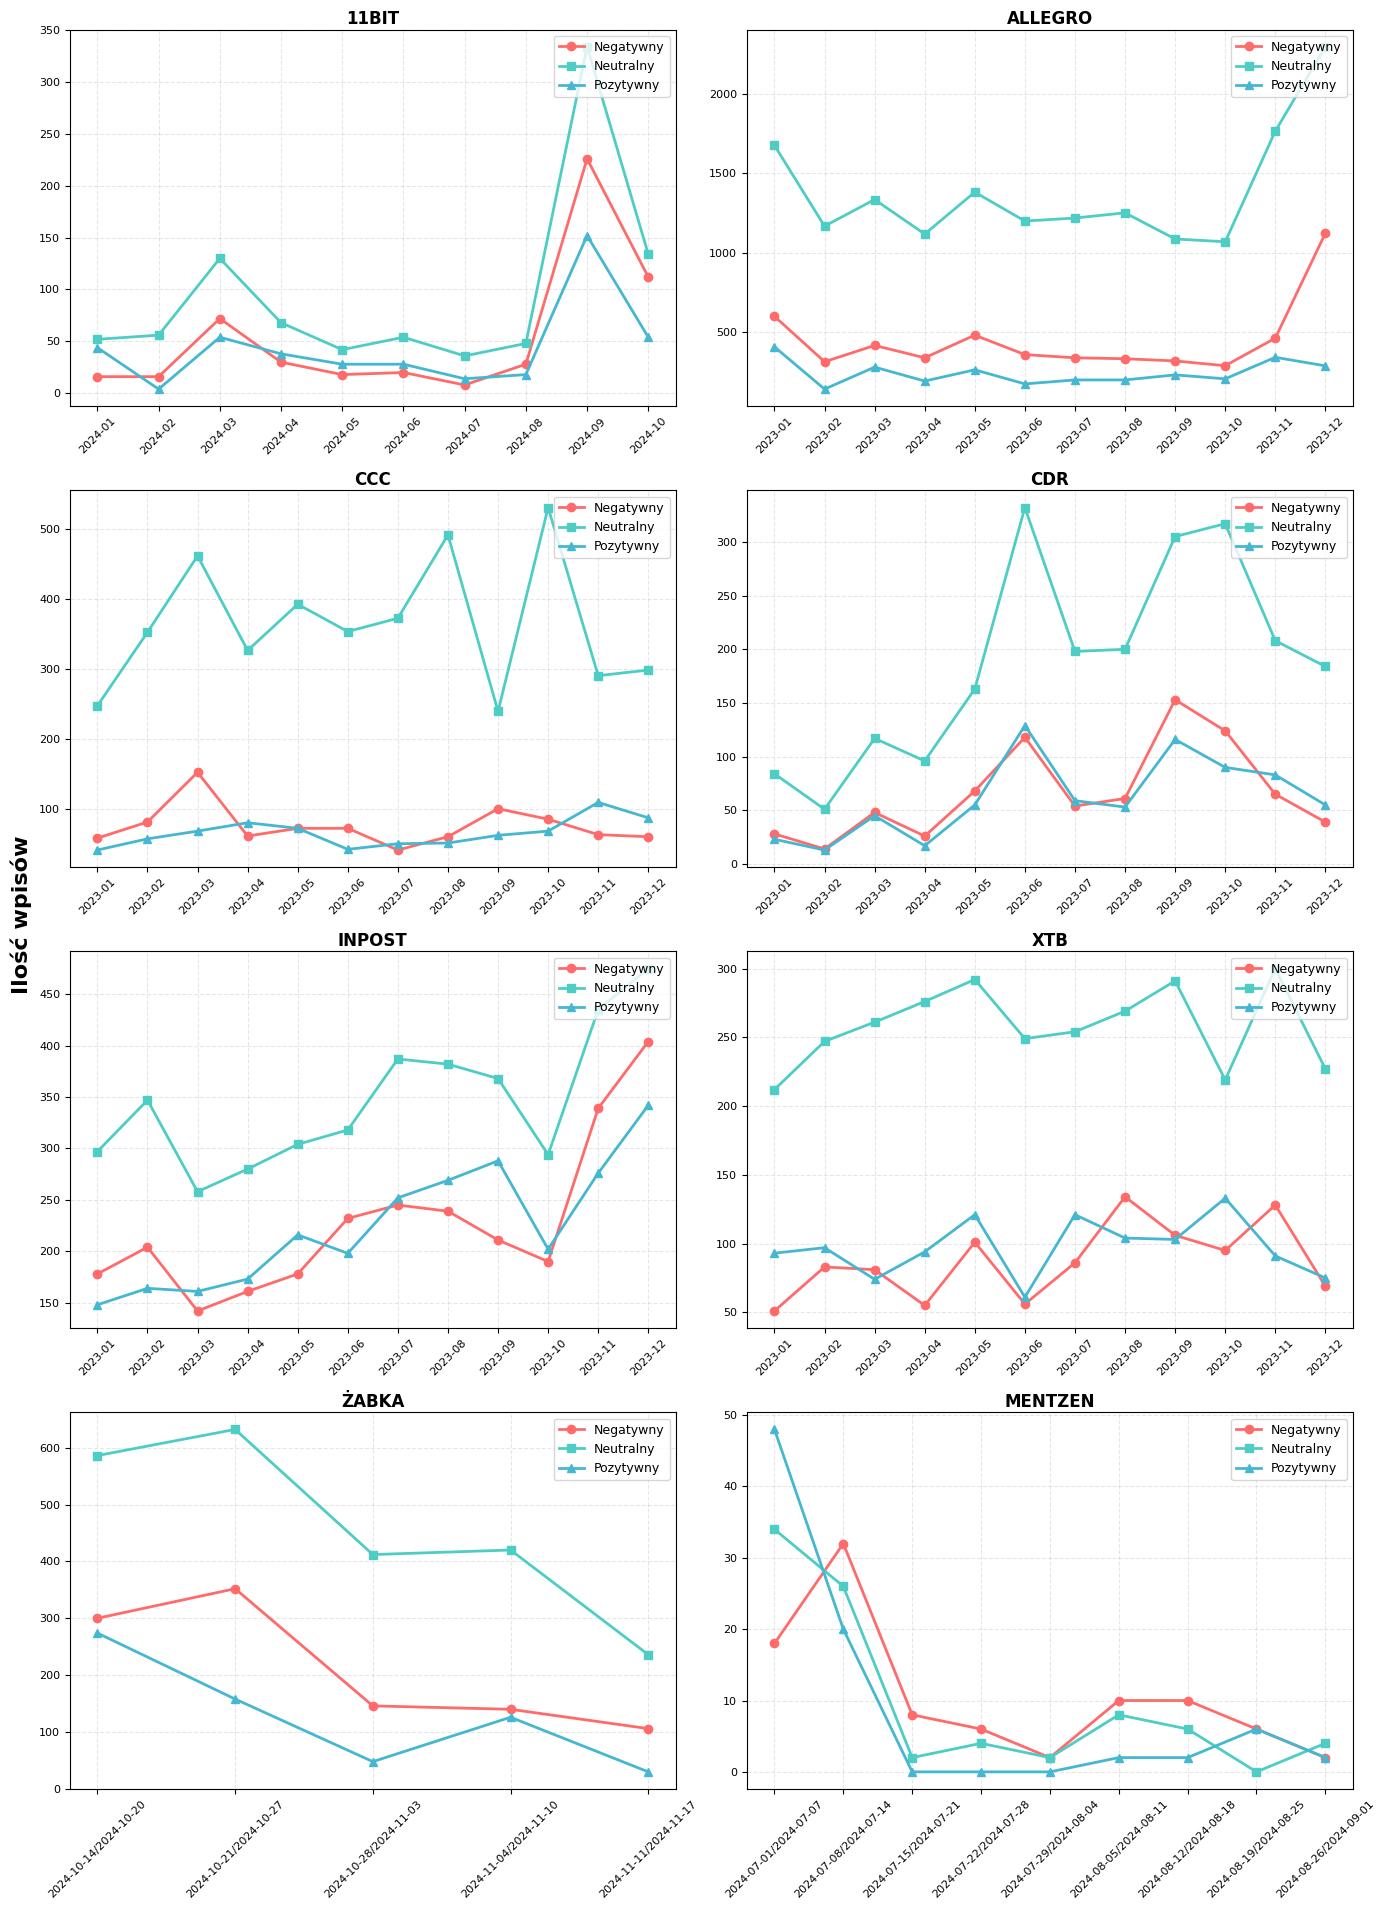

In [53]:
colors = {'Negative': '#FF6B6B', 'Neutral': '#4ECDC4', 'Positive': '#45B7D1'}
markers = {'Negative': 'o', 'Neutral': 's', 'Positive': '^'}
names = {'Negative': 'Negatywne',
         'Neutral': 'Neutralne',
         'Positive': 'Pozytywne'}

# Get company names and set fixed subplot layout
company_names = list(companies_data_daily.keys())

# Reorder companies: put zabka and mentzen at the end
weekly_companies = ['zabka', 'mentzen']
monthly_companies = [company for company in company_names 
                    if company.lower() not in [c.lower() for c in weekly_companies]]

# Create final ordered list with weekly companies last
ordered_companies = monthly_companies + [company for company in company_names 
                                       if company.lower() in [c.lower() for c in weekly_companies]]

n_companies = len(ordered_companies)

# Fixed layout: 2 columns and 4 rows
n_cols = 2
n_rows = 4

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))

# Handle case where there's only one subplot
if n_companies == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for idx, company in enumerate(ordered_companies):
    df = companies_data_daily[company]
    company_data = df.copy()
    
    # Check if company should use weekly aggregation
    if company.lower() in ['żabka', 'mentzen']:
        # Weekly aggregation
        company_data['Week'] = company_data['Date'].dt.to_period('W')
        period_sentiment = company_data.groupby('Week').agg({
            'Negative': 'sum',
            'Neutral': 'sum', 
            'Positive': 'sum',
            'tweet_volume': 'sum',
            'total_views': 'sum'
        }).reset_index()
        x_values = period_sentiment['Week'].astype(str)
        period_label = 'Tydzień'
    else:
        # Monthly aggregation
        company_data['Month'] = company_data['Date'].dt.to_period('M')
        period_sentiment = company_data.groupby('Month').agg({
            'Negative': 'sum',
            'Neutral': 'sum', 
            'Positive': 'sum',
            'tweet_volume': 'sum',
            'total_views': 'sum'
        }).reset_index()
        x_values = period_sentiment['Month'].astype(str)
        period_label = 'Miesiąc'
    
    # Get current axis
    ax = axes_flat[idx]
    
    # Plot each sentiment line
    ax.plot(x_values, period_sentiment['Negative'], 
            color=colors['Negative'], marker=markers['Negative'],
            linewidth=2, label='Negatywny', markersize=6)
    
    ax.plot(x_values, period_sentiment['Neutral'], 
            color=colors['Neutral'], marker=markers['Neutral'],
            linewidth=2, label='Neutralny', markersize=6)
    
    ax.plot(x_values, period_sentiment['Positive'], 
            color=colors['Positive'], marker=markers['Positive'],
            linewidth=2, label='Pozytywny', markersize=6)
    
    # Customize each subplot
    ax.set_title(f'{company}', 
                fontsize=12, fontweight='bold', pad=4)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend
    ax.legend(fontsize=9, loc='upper right')
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide empty subplots if any
for idx in range(n_companies, len(axes_flat)):
    axes_flat[idx].set_visible(False)

# Adjust layout
#plt.suptitle('Sentiment Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)

fig.text(0.01, 0.5, 'Ilość wpisów', 
         va='center', rotation='vertical', 
         fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0.02, 0, 1, 0.96])
# Show the plot



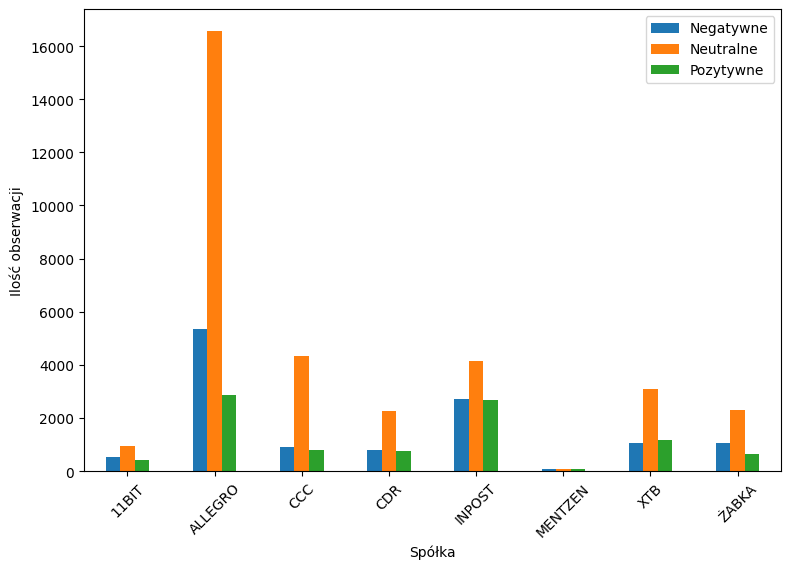

In [54]:
selected_columns = ['Negative','Neutral','Positive'] 
counts = grouped_metrics.groupby(['company'])[selected_columns].sum()

ax = counts.plot(kind='bar', figsize=(9, 6))
plt.xlabel('Spółka')
plt.ylabel('Ilość obserwacji')
plt.xticks(rotation=45)
ax.legend(['Negatywne', 'Neutralne', 'Pozytywne']) 
plt.show()


In [55]:
correlation_results = {}

for company in companies:
    correlation_results[company] = {}
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]
    df_results = []  # Collect results for all lags
    x = df[stock_columns]
    y = df[tweet_columns]
    
    # Calculate correlation matrix
    corr_matrix = pd.concat([x, y], axis=1).corr()
    
    # Extract correlations between tweet_columns and stock_columns
    correlations = corr_matrix.loc[tweet_columns, stock_columns].reset_index()
    correlations = correlations.melt(id_vars='index', var_name='pair', value_name=f'Correlation')
    correlations['Correlation'] = correlations['Correlation'].round(2)
    df_results.append(correlations)
    
    # Combine all lag correlation results
    df_combined = df_results[0]
    df_combined = df_combined.sort_values('Correlation', key=lambda x: abs(x), ascending=False)
    correlation_results[company] = df_combined
    
    print(company)
    #display(df_combined.head())


11BIT
ALLEGRO
CCC
CDR
INPOST
XTB
MENTZEN
ŻABKA


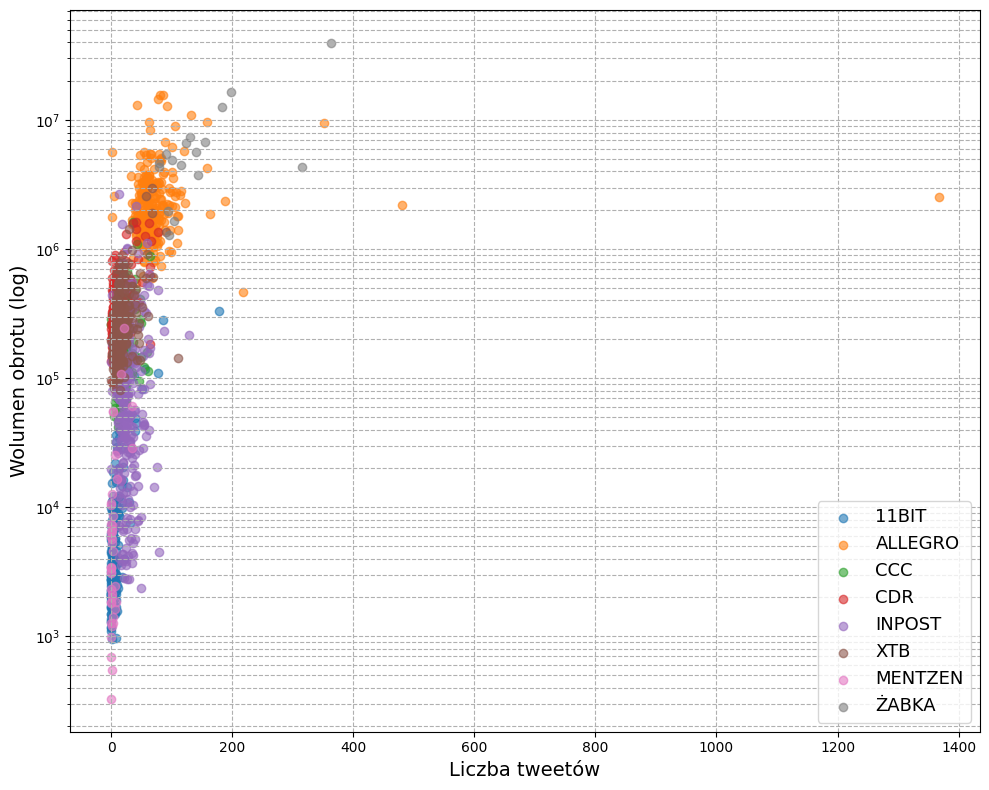

In [56]:
plt.figure(figsize=(10, 8))
for company in companies:
    company_data = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]
    plt.scatter(company_data['tweet_volume'], company_data['Wolumen'], 
                alpha=0.6, label=company)

#plt.title('Aktywność tweetów vs wolumen obrotu')
plt.xlabel('Liczba tweetów', fontsize=14)
plt.ylabel('Wolumen obrotu (log)',fontsize=14)
plt.yscale('log')
plt.legend(fontsize=13)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

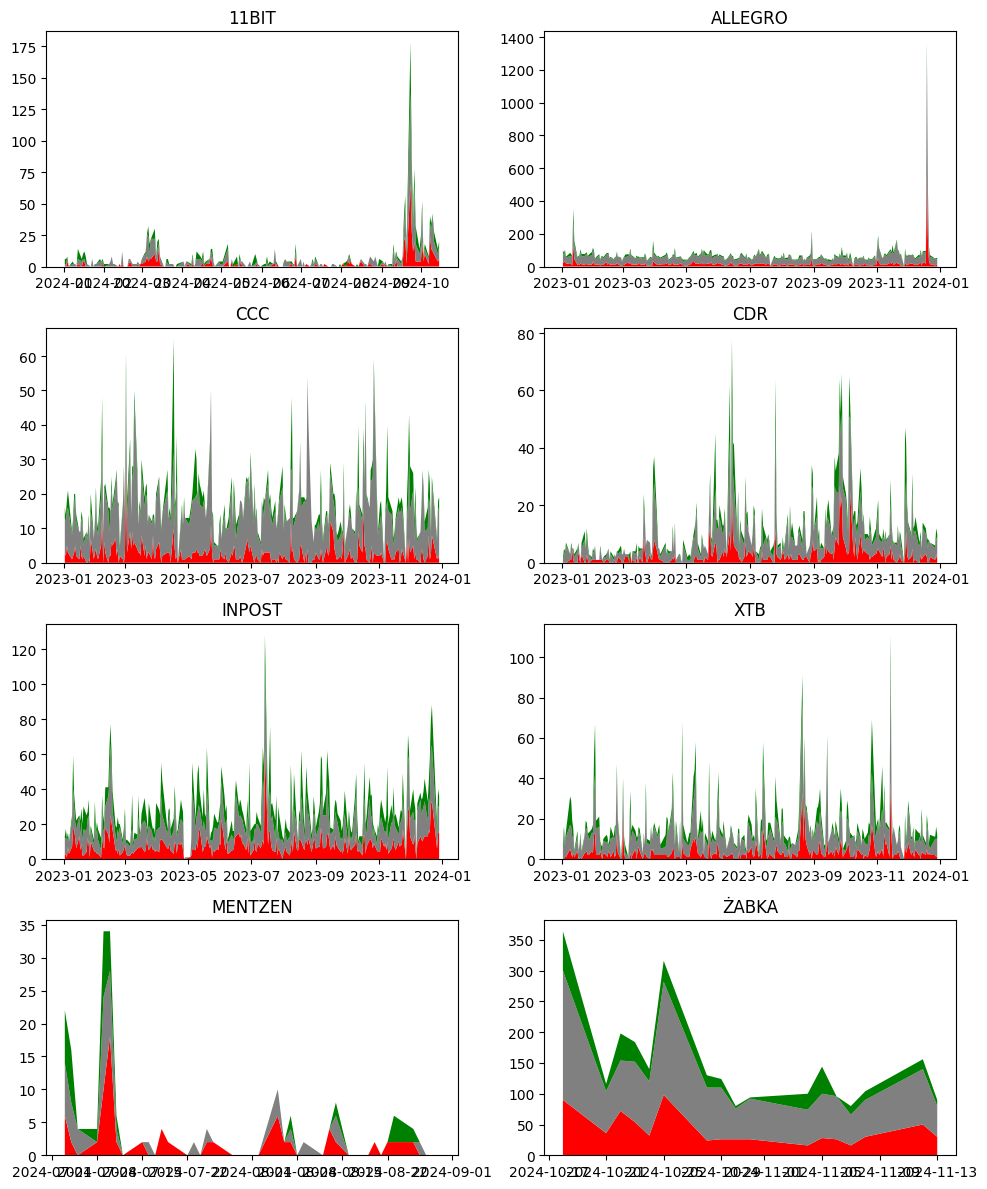

In [57]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()
for i, company in enumerate(companies):
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()

    dates = df['Date']
    negative = df['Negative']
    neutral = df['Neutral']
    positive = df['Positive']

    axes[i].stackplot(dates, negative, neutral, positive, 
                  labels=['Negatywne', 'Neutralne', 'Pozytywne'],
                  colors=['red', 'gray', 'green'])

    axes[i].set_title(company)
plt.tight_layout()
   

<Figure size 1000x600 with 0 Axes>

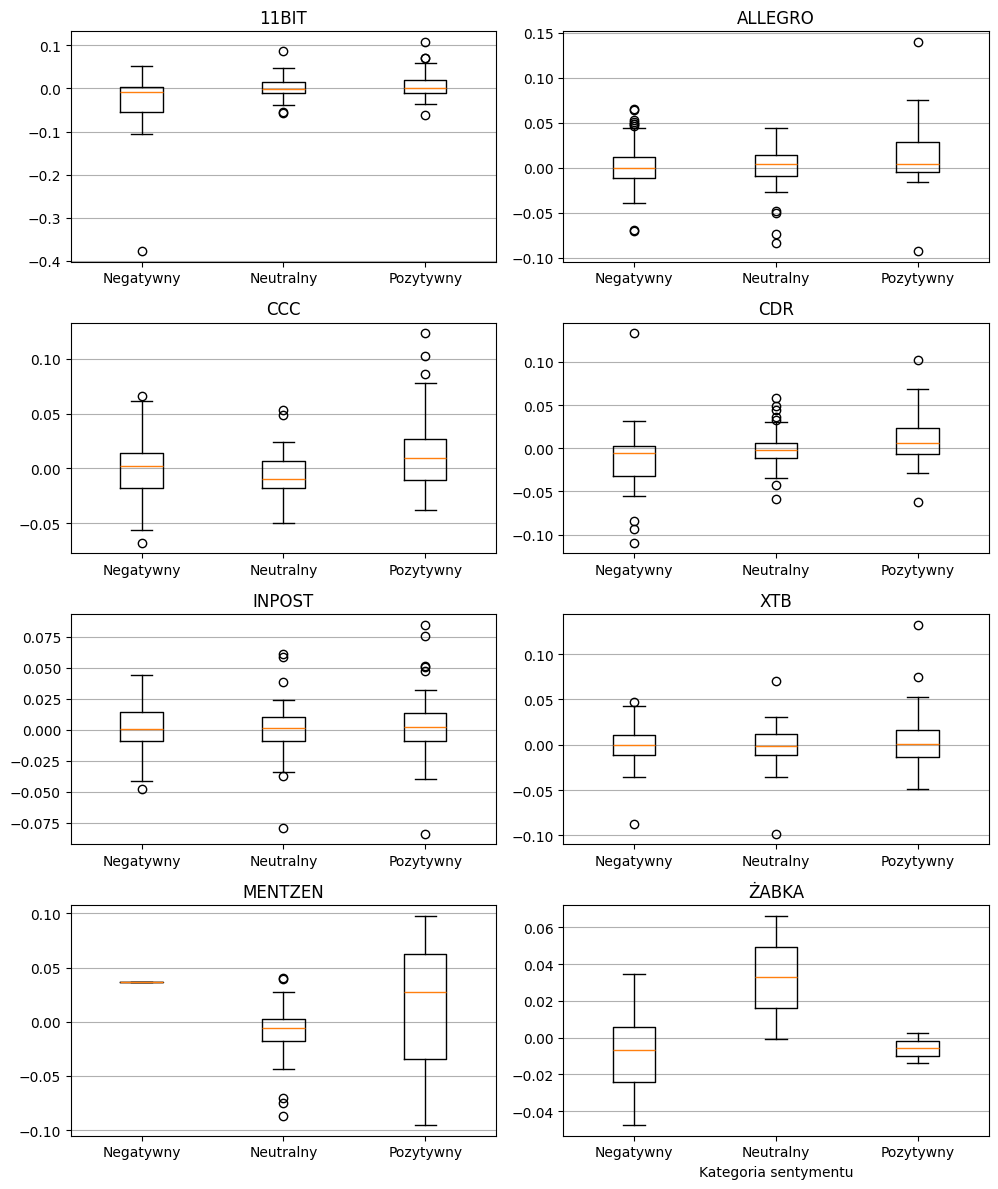

In [58]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))
axes = axes.flatten()
for i, company in enumerate(companies):
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()

    sentiment_labels = ['Negatywny', 'Neutralny', 'Pozytywny']
    bins = [-1, -0.1, 0.1, 1]  # Define sentiment polarity bins
    df.loc[:,'sentiment_category'] = pd.cut(df['sentiment_polarity'], 
                                                bins=bins, 
                                                labels=sentiment_labels)

    axes[i].boxplot([df[df['sentiment_category'] == cat]['Return'] for cat in sentiment_labels],
                labels=sentiment_labels)
    axes[i].set_title(company)
    axes[i].grid(axis='y')
    
    plt.xlabel('Kategoria sentymentu')
plt.tight_layout()
   

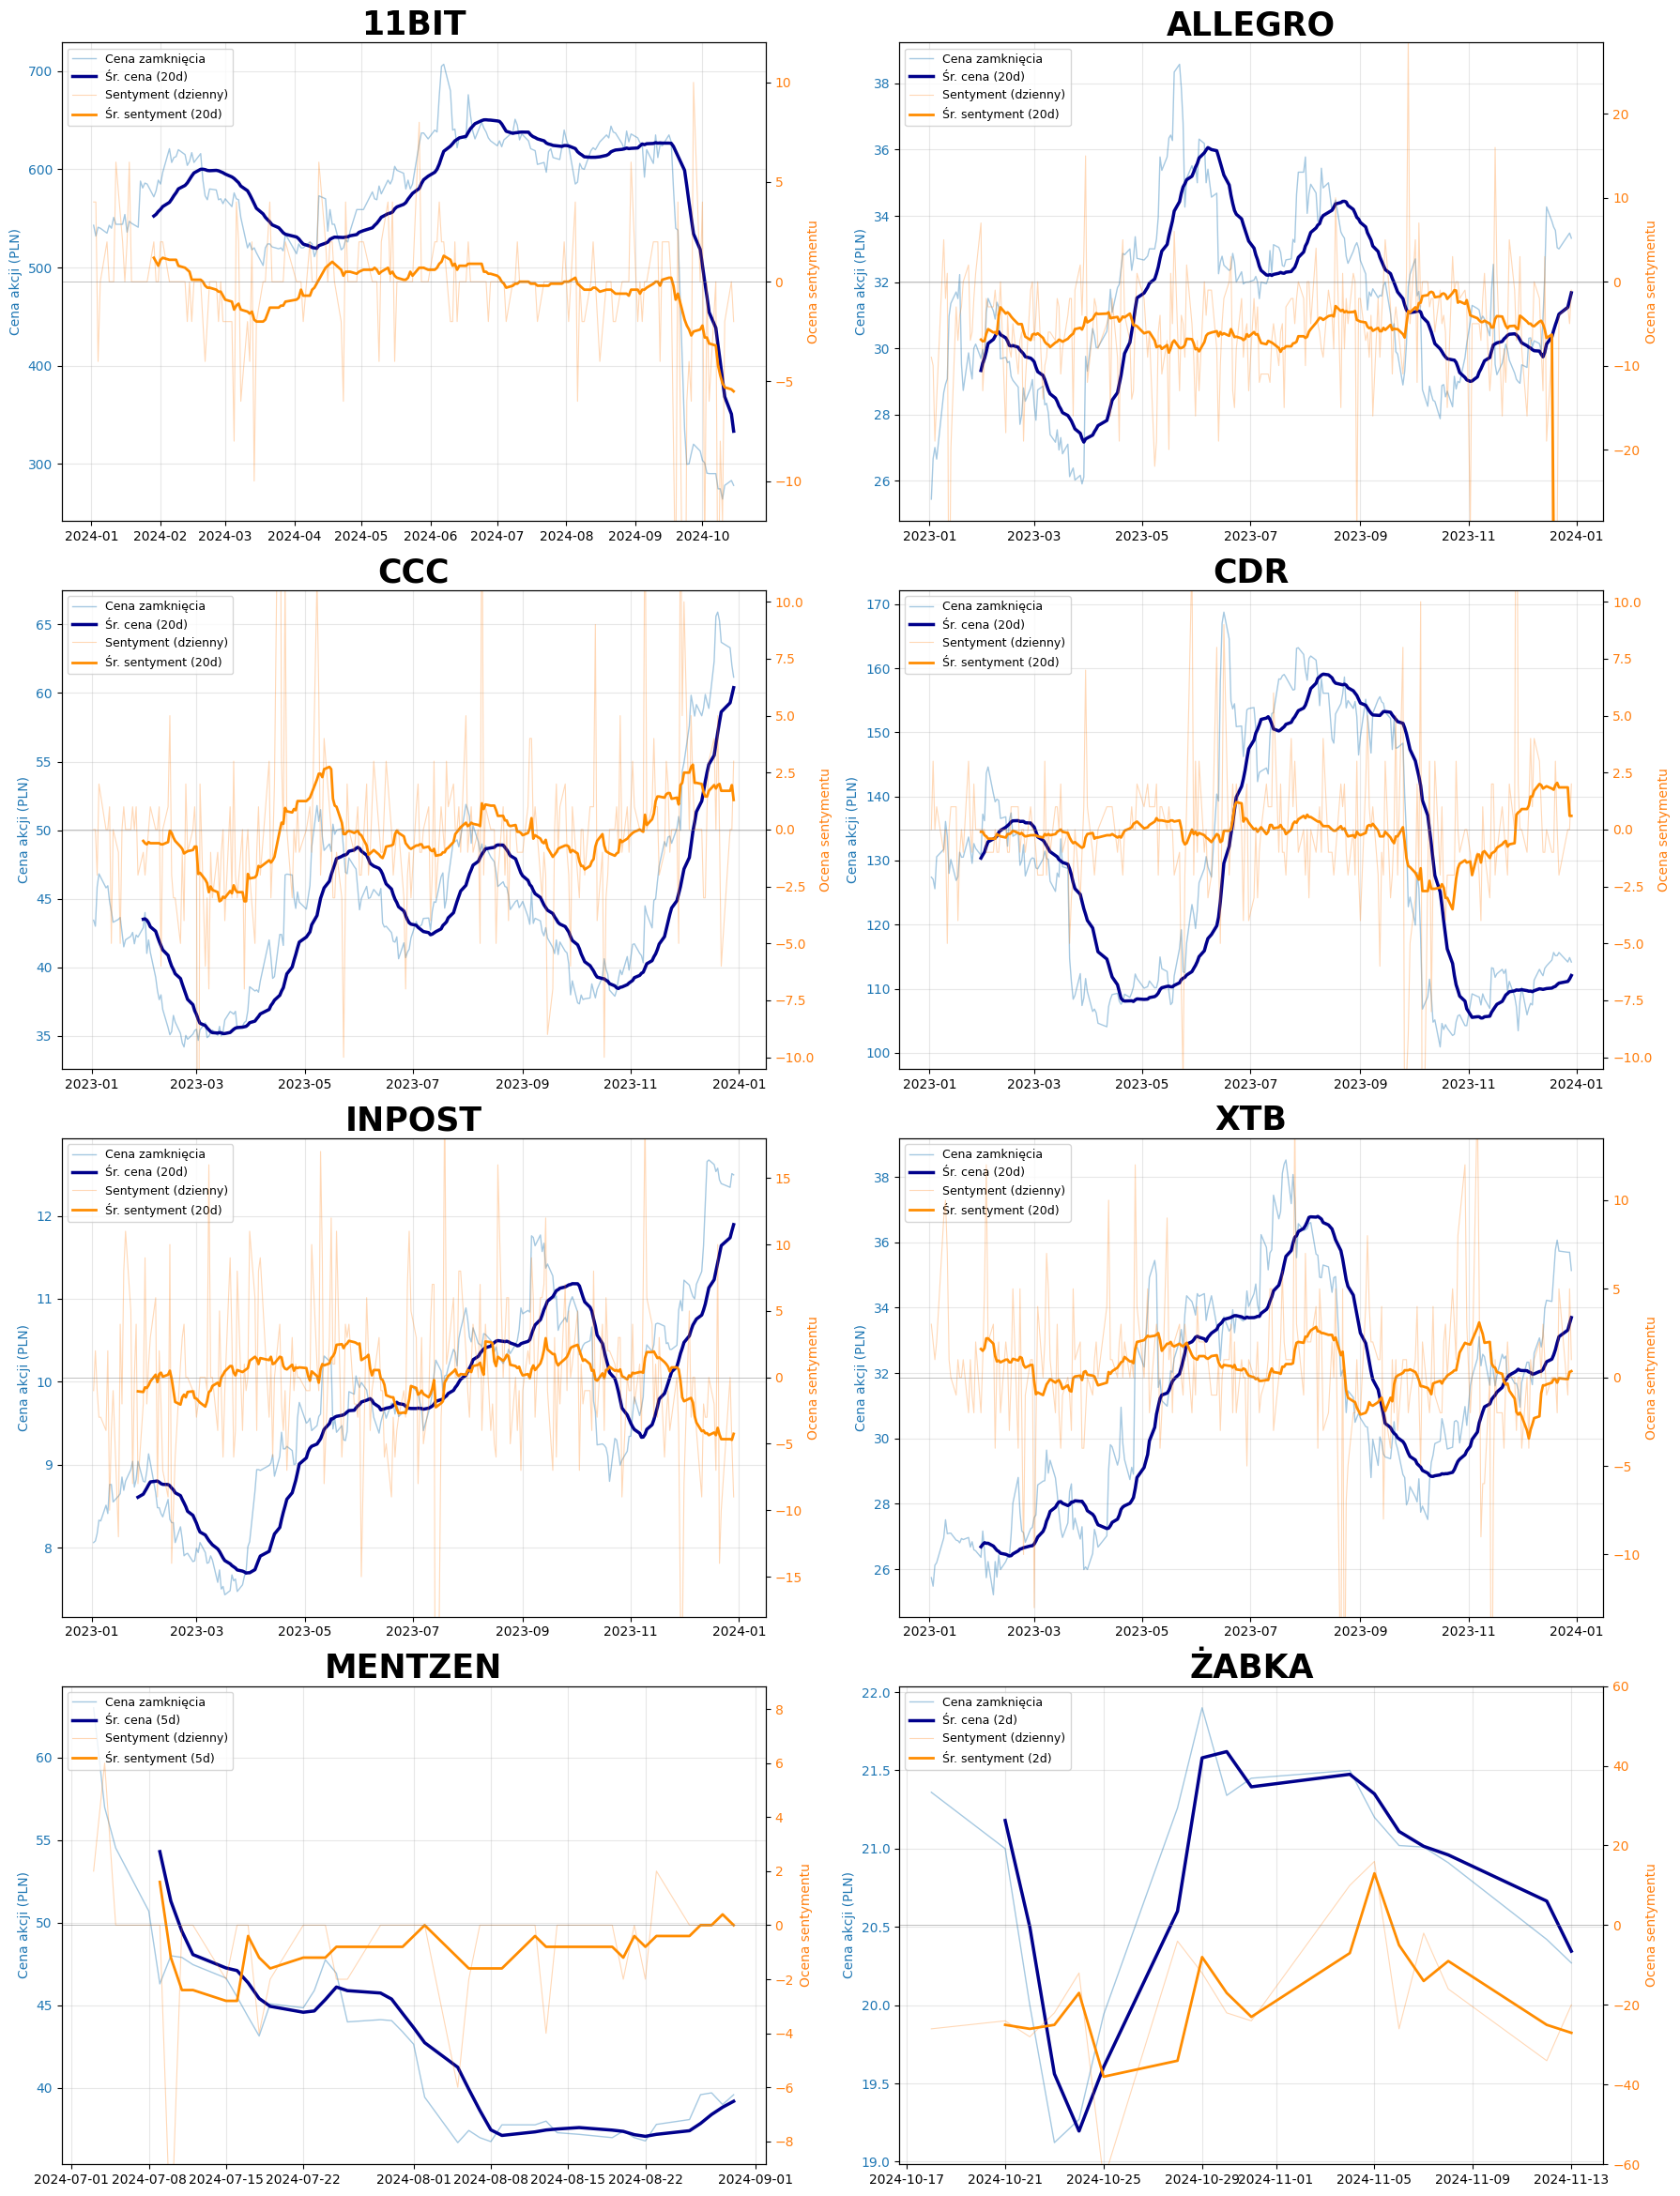

In [59]:
# Create 4x2 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 25))
axes = axes.flatten()

# Default MA windows (used for non-special companies)
DEFAULT_PRICE_MA_WINDOW = 20
DEFAULT_SENTIMENT_MA_WINDOW = 20

# Special MA window configurations for ŻABKA and MENTZEN
SPECIAL_MA_WINDOWS = {
    "ŻABKA": {"price": 2, "sentiment": 2},  # Longer-term smoothing
    "MENTZEN": {"price": 5, "sentiment": 5}  # Shorter-term smoothing
}

for i, company in enumerate(companies):
    # Determine MA windows for this company
    if company in SPECIAL_MA_WINDOWS:
        price_window = SPECIAL_MA_WINDOWS[company]["price"]
        sentiment_window = SPECIAL_MA_WINDOWS[company]["sentiment"]
    else:
        price_window = DEFAULT_PRICE_MA_WINDOW
        sentiment_window = DEFAULT_SENTIMENT_MA_WINDOW

    # Filter company data
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()
    
    if df.empty:
        print(f"No data available for {company}, skipping...")
        axes[i].axis('off')
        continue
        
    # ---- STOCK PRICE AXIS ----
    ax1 = axes[i]
    ax1.plot(df['Date'], df['Zamkniecie'], color='tab:blue', linewidth=1.0, 
             alpha=0.4, label='Cena zamknięcia')
    
    # Use customized price MA window
    price_ma = df['Zamkniecie'].rolling(price_window).mean()
    ax1.plot(df['Date'], price_ma, color='darkblue', linewidth=2.5, 
             label=f'Śr. cena ({price_window}d)')
    
    ax1.set_ylabel('Cena akcji (PLN)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_title(f'{company}', fontsize=25, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # ---- SENTIMENT AXIS ----
    ax2 = ax1.twinx()
    sentiment = df['sentiment_score'].dropna()
    
    if sentiment.empty:
        cap_value = 1.0
        ax2.set_ylabel('Brak danych sentymentu', color='tab:orange')
    else:
        ax2.plot(df['Date'], sentiment, color='tab:orange', linewidth=0.8, 
                 alpha=0.3, label='Sentyment (dzienny)')
        
        # Use customized sentiment MA window
        sentiment_ma = df['sentiment_score'].rolling(sentiment_window).mean()
        ax2.plot(df['Date'], sentiment_ma, color='darkorange', linewidth=2.0,
                 label=f'Śr. sentyment ({sentiment_window}d)')
        
        cap_value = np.percentile(np.abs(sentiment), 95) * 1.5
        ax2.set_ylabel('Ocena sentymentu', color='tab:orange')
    
    ax2.axhline(0, color='gray', linestyle='-', alpha=0.5, linewidth=0.7)
    ax2.set_ylim(-cap_value, cap_value)
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # ---- LEGEND & FINAL TOUCHES ----
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

# Add common labels and adjust layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

plt.show()

## Time Series Approach

### ADF test for stationarity

In [60]:
# Initialize results dictionaries
stationarity_results = {}

# Lists of variables
STOCK = stock_columns
TWITTER = tweet_columns

# Stationarity threshold
stationarity_p_threshold = 0.05  # p-value threshold for stationarity
# Check stationarity for each variable
for company in companies:
    stationarity_results[company] = {'STOCK': {}, 'TWITTER': {}}
    
    for variable in STOCK + TWITTER:
        # Extract data for the specific variable and company
        series = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company][variable].dropna()
        
        # Perform the ADF test
        result = adfuller(series)
        p_value = result[1]
        
        # Store whether the variable is stationary
        category = 'STOCK' if variable in STOCK else 'TWITTER'
        stationarity_results[company][category][variable] = p_value < stationarity_p_threshold


In [61]:
stationary_columns = {}

for company, stock_tweet_res in stationarity_results.items():
    stationary_columns[company] = {'STOCK': [], 'TWITTER': []}
    for stock_tweet, res in stock_tweet_res.items():
        stationary = []
        for column, is_stationary in res.items():
            if is_stationary:
                stationary.append(column) 
        stationary_columns[company][stock_tweet] =  stationary

In [62]:
records = []
for company, categories in stationary_columns.items():
    for category, features in categories.items():
        for feature in features:
            records.append((company, category, feature))


df = pd.DataFrame(records, columns=['Company', 'Category', 'Feature'])
df['Feature'] = df['Feature'].replace(column_labels_pl)
df['Category'] = df['Category'].replace({'STOCK':'GIEŁDA'})

In [63]:
df_to_plot = df.groupby(['Company','Category']).count()
df_to_plot = df_to_plot.reset_index()

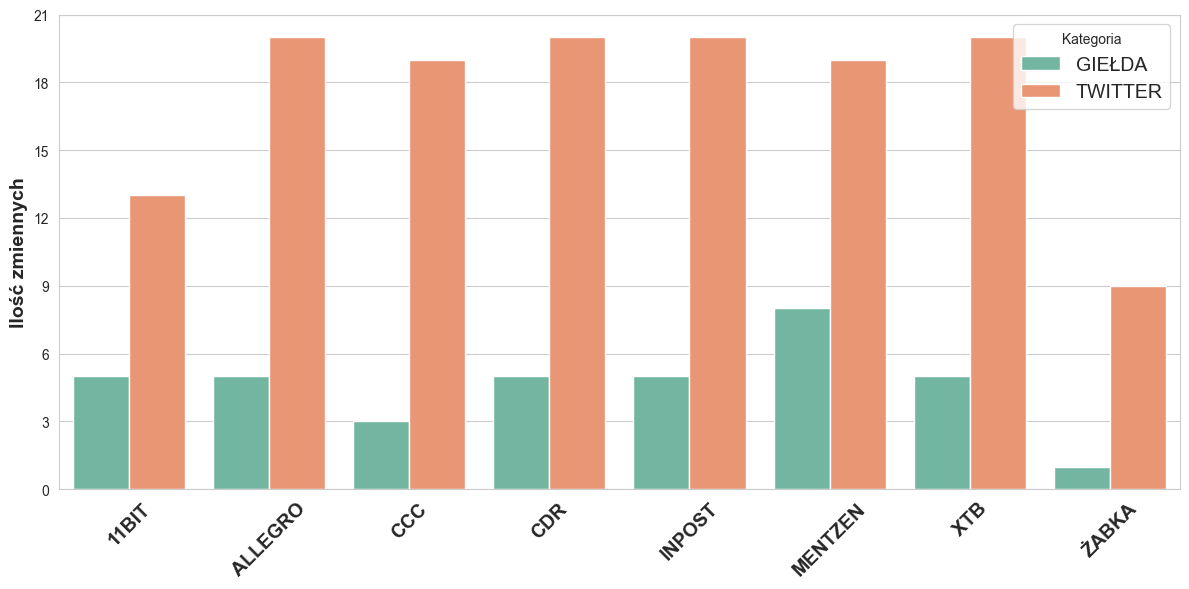

In [64]:
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create a grouped barplot
sns.barplot(data=df_to_plot, x='Company', y='Feature', hue='Category', palette='Set2')

# Force y-axis ticks to be integers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Customize the plot
plt.ylabel('Ilość zmiennych',fontsize=14, fontweight = 'bold')
plt.xlabel('')
plt.xticks(rotation=45, fontsize = 14,fontweight = 'bold')
plt.legend(title='Kategoria', loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()

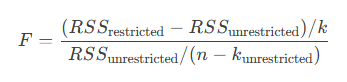

In [65]:

# Initialize results dictionaries
autocorrelation_results_ord = {}
autocorr_p_threshold = 0.05
max_lags = 20  # Increase to better detect order

# Check autocorrelation for each variable
for company in companies:
    STOCK = [k for k,v in stationarity_results[company]['STOCK'].items() if v]
    TWITTER = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
    autocorrelation_results_ord[company] = {'STOCK': {}, 'TWITTER': {}}
    
    for variable in STOCK + TWITTER:
        series = companies_data_daily_final_full[
            companies_data_daily_final_full['company'] == company
        ][variable].dropna()
        
        if len(series) <= max_lags:
            category = 'STOCK' if variable in STOCK else 'TWITTER'
            autocorrelation_results_ord[company][category][variable] = 1  # Default block size
            continue
        
        # Ljung-Box test for each lag
        ljung_box_result = acorr_ljungbox(series, lags=max_lags, return_df=True)
        p_values = ljung_box_result['lb_pvalue']
        
        # Find the order - last significant lag
        significant_lags = np.where(p_values < autocorr_p_threshold)[0]
        
        if len(significant_lags) == 0:
            autocorr_order = 0  # No autocorrelation, use block size 1
        else:
            autocorr_order = significant_lags[-1] + 1  # +1 because index starts at 0
        
        category = 'STOCK' if variable in STOCK else 'TWITTER'
        autocorrelation_results_ord[company][category][variable] = autocorr_order

print("AUTOCORRELATION ORDER (for block bootstrap):")
print("=" * 50)
pprint.pprint(autocorrelation_results_ord)

AUTOCORRELATION ORDER (for block bootstrap):
{'11BIT': {'STOCK': {'Change': 0,
                     'Direction': 20,
                     'Return': 0,
                     'Wolumen': 20,
                     'volatility': 20},
           'TWITTER': {'Positive': 20,
                       'amplified_sentiment': 0,
                       'engagement_impact': 0,
                       'retweet_count_Neutral': 20,
                       'sentiment_divergence': 0,
                       'sentiment_intensity': 3,
                       'sentiment_polarity': 17,
                       'sentiment_score_views': 3,
                       'total_views': 20,
                       'view_count_Negative': 20,
                       'view_count_Neutral': 20,
                       'view_count_Positive': 20,
                       'view_weighted_polarity': 0}},
 'ALLEGRO': {'STOCK': {'Change': 0,
                       'Direction': 1,
                       'Return': 0,
                       'Wolumen

In [35]:
warnings.filterwarnings("ignore", category=ValueWarning)
granger_results = {}
granger_p_threshold = 0.05

for company, results in stationarity_results.items():
    granger_results[company] = {}
    
    # Get company-specific data
    df_company = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()
    df_company.index = pd.to_datetime(df_company['Date'])
    df_company = df_company.asfreq('D') 
    stationary_stock = stationary_columns[company]['STOCK']
    stationary_twitter = stationary_columns[company]['TWITTER']

    for stock_var in stationary_stock:
        granger_results[company][stock_var] = {}
        
        for twitter_var in stationary_twitter:
            df_diff = df_company[[stock_var, twitter_var]].dropna()
            n_obs = len(df_diff)
            # Check minimum observations
            if n_obs < 50:  # Need sufficient observations
                print(f"Skipping {company} - {stock_var} vs {twitter_var}: not enough data")
                continue
                
            # FIX 1: Create model instance for each pair
            model = VAR(df_diff)
            
            # FIX 2: Proper lag selection bounds
            max_possible_lags = min(len(df_diff)//4, 20)  # Cap at reasonable level
            lag_selection = model.select_order(maxlags=max_possible_lags)
            
            # FIX 3: Better optimal lag selection
            optimal_lags = max(1, lag_selection.aic)  # Ensure at least 1
    
            try:
                # FIX 4: Use maxlags parameter correctly
                var_results = model.fit(maxlags=optimal_lags)
                
                # FIX 5: Correct causality test - returns single result, not dict
                granger_test = var_results.test_causality(
                    caused=stock_var,      # Effect variable
                    causing=twitter_var,   # Cause variable  
                    kind='f'
                )
                
                # Extract test results properly
                f_stat = granger_test.test_statistic
                p_val = granger_test.pvalue
                is_significant = p_val < granger_p_threshold
                
                # Model stability
                is_stable = var_results.is_stable()
                
                # FIX 6: Improved residual diagnostics
                diagnostics = {}
                residuals = var_results.resid

                if min(10, n_obs // 5) <= optimal_lags:
                      lag_to_use = optimal_lags + 1
                else:
                      lag_to_use = min(10, len(residuals)//4)
    
                if lag_to_use > 0:
                    is_res_correlated = var_results.test_whiteness(nlags=lag_to_use )
                else:
                    is_res_correlated = None
                
                # ARCH test for heteroskedasticity
                for col in df_diff.columns:
                    try:
                        arch_test = het_arch(residuals.loc[:,col], nlags=min(5, n_obs//10))
                        is_res_heteroskedastic = arch_test[1] < 0.05
                        diagnostics[col] = is_res_heteroskedastic
                    except Exception as e:
                        None
                
                # FIX 7: Store results correctly
                granger_results[company][stock_var][twitter_var] = {
                    'f_statistic': f_stat,
                    'p_value': p_val,
                    'is_significant': is_significant,
                    'model_stable': is_stable,
                    'diagnostics': diagnostics,
                    'is_residuals_correlated': is_res_correlated.pvalue < 0.05,
                    'optimal_lags': optimal_lags,
                    'n_observations': len(df_diff)
                }
                
            except Exception as e:
                # Handle estimation failures
                print(company)
                print(e)
              

Skipping MENTZEN - Najwyzszy vs Negative: not enough data
Skipping MENTZEN - Najwyzszy vs Neutral: not enough data
Skipping MENTZEN - Najwyzszy vs Positive: not enough data
Skipping MENTZEN - Najwyzszy vs view_count_Negative: not enough data
Skipping MENTZEN - Najwyzszy vs view_count_Neutral: not enough data
Skipping MENTZEN - Najwyzszy vs view_count_Positive: not enough data
Skipping MENTZEN - Najwyzszy vs total_retweet_count: not enough data
Skipping MENTZEN - Najwyzszy vs retweet_count_Negative: not enough data
Skipping MENTZEN - Najwyzszy vs retweet_count_Neutral: not enough data
Skipping MENTZEN - Najwyzszy vs retweet_count_Positive: not enough data
Skipping MENTZEN - Najwyzszy vs tweet_volume: not enough data
Skipping MENTZEN - Najwyzszy vs sentiment_score_views: not enough data
Skipping MENTZEN - Najwyzszy vs total_views: not enough data
Skipping MENTZEN - Najwyzszy vs sentiment_polarity: not enough data
Skipping MENTZEN - Najwyzszy vs view_weighted_polarity: not enough data
Ski

In [36]:
pprint.pprint(granger_results)

{'11BIT': {'Change': {'Positive': {'diagnostics': {'Change': False,
                                                   'Positive': False},
                                   'f_statistic': 1.5018096875611813,
                                   'is_residuals_correlated': False,
                                   'is_significant': False,
                                   'model_stable': True,
                                   'n_observations': 200,
                                   'optimal_lags': 3,
                                   'p_value': 0.2136491789026343},
                      'amplified_sentiment': {'diagnostics': {'Change': False,
                                                              'amplified_sentiment': False},
                                              'f_statistic': 2.82766533367615,
                                              'is_residuals_correlated': False,
                                              'is_significant': False,
                        

In [37]:
def flatten_granger_results(granger_dict):
    rows = []
    for company, company_data in granger_results.items():
        for target, target_data in company_data.items():
            for source, cont in target_data.items():

            # Extract diagnostics and significant lags
                diagnostics = cont['diagnostics']
                lags = cont['optimal_lags']
                model_stable = cont['model_stable']
                
                # Calculate aggregate diagnostics flags
                heteroskedastic = any(diag for diag in diagnostics.values())
                                      
                rows.append({
                    "Company": company,
                    "Target Variable": target,
                    "Source Feature": source,
                    "Lag": lags,
                    "Significant": cont['is_significant'],
                    "Any Autocorrelation": cont['is_residuals_correlated'],
                    "Any Heteroskedasticity": heteroskedastic,
                    "Model Stable": model_stable
                })
    return pd.DataFrame(rows)

1. diagnostics of restricted and unrestrited models
2. Running bootstrap to see compare the results
3. Running https://github.com/mrosol/Nonlincausality

In [38]:
df_granger = flatten_granger_results(granger_results)
df_granger['Flag'] = (
    df_granger['Any Autocorrelation'] |
    df_granger['Any Heteroskedasticity'] |
    ~df_granger['Model Stable']
)

In [39]:
df_granger[df_granger['Flag']==True].groupby(['Company', 'Target Variable']).agg(
    Count=('Flag', 'size'),
    was_significant=('Significant', 'sum'),
    Autocorrelation_Issues=('Any Autocorrelation', 'sum'),
    Heteroskedasticity_Issues=('Any Heteroskedasticity', 'sum'),
    Not_Stable=('Model Stable', lambda x: (~x).sum())
).reset_index().sort_values(by='Count', ascending=False)
df = df_granger[df_granger['Flag']==False]

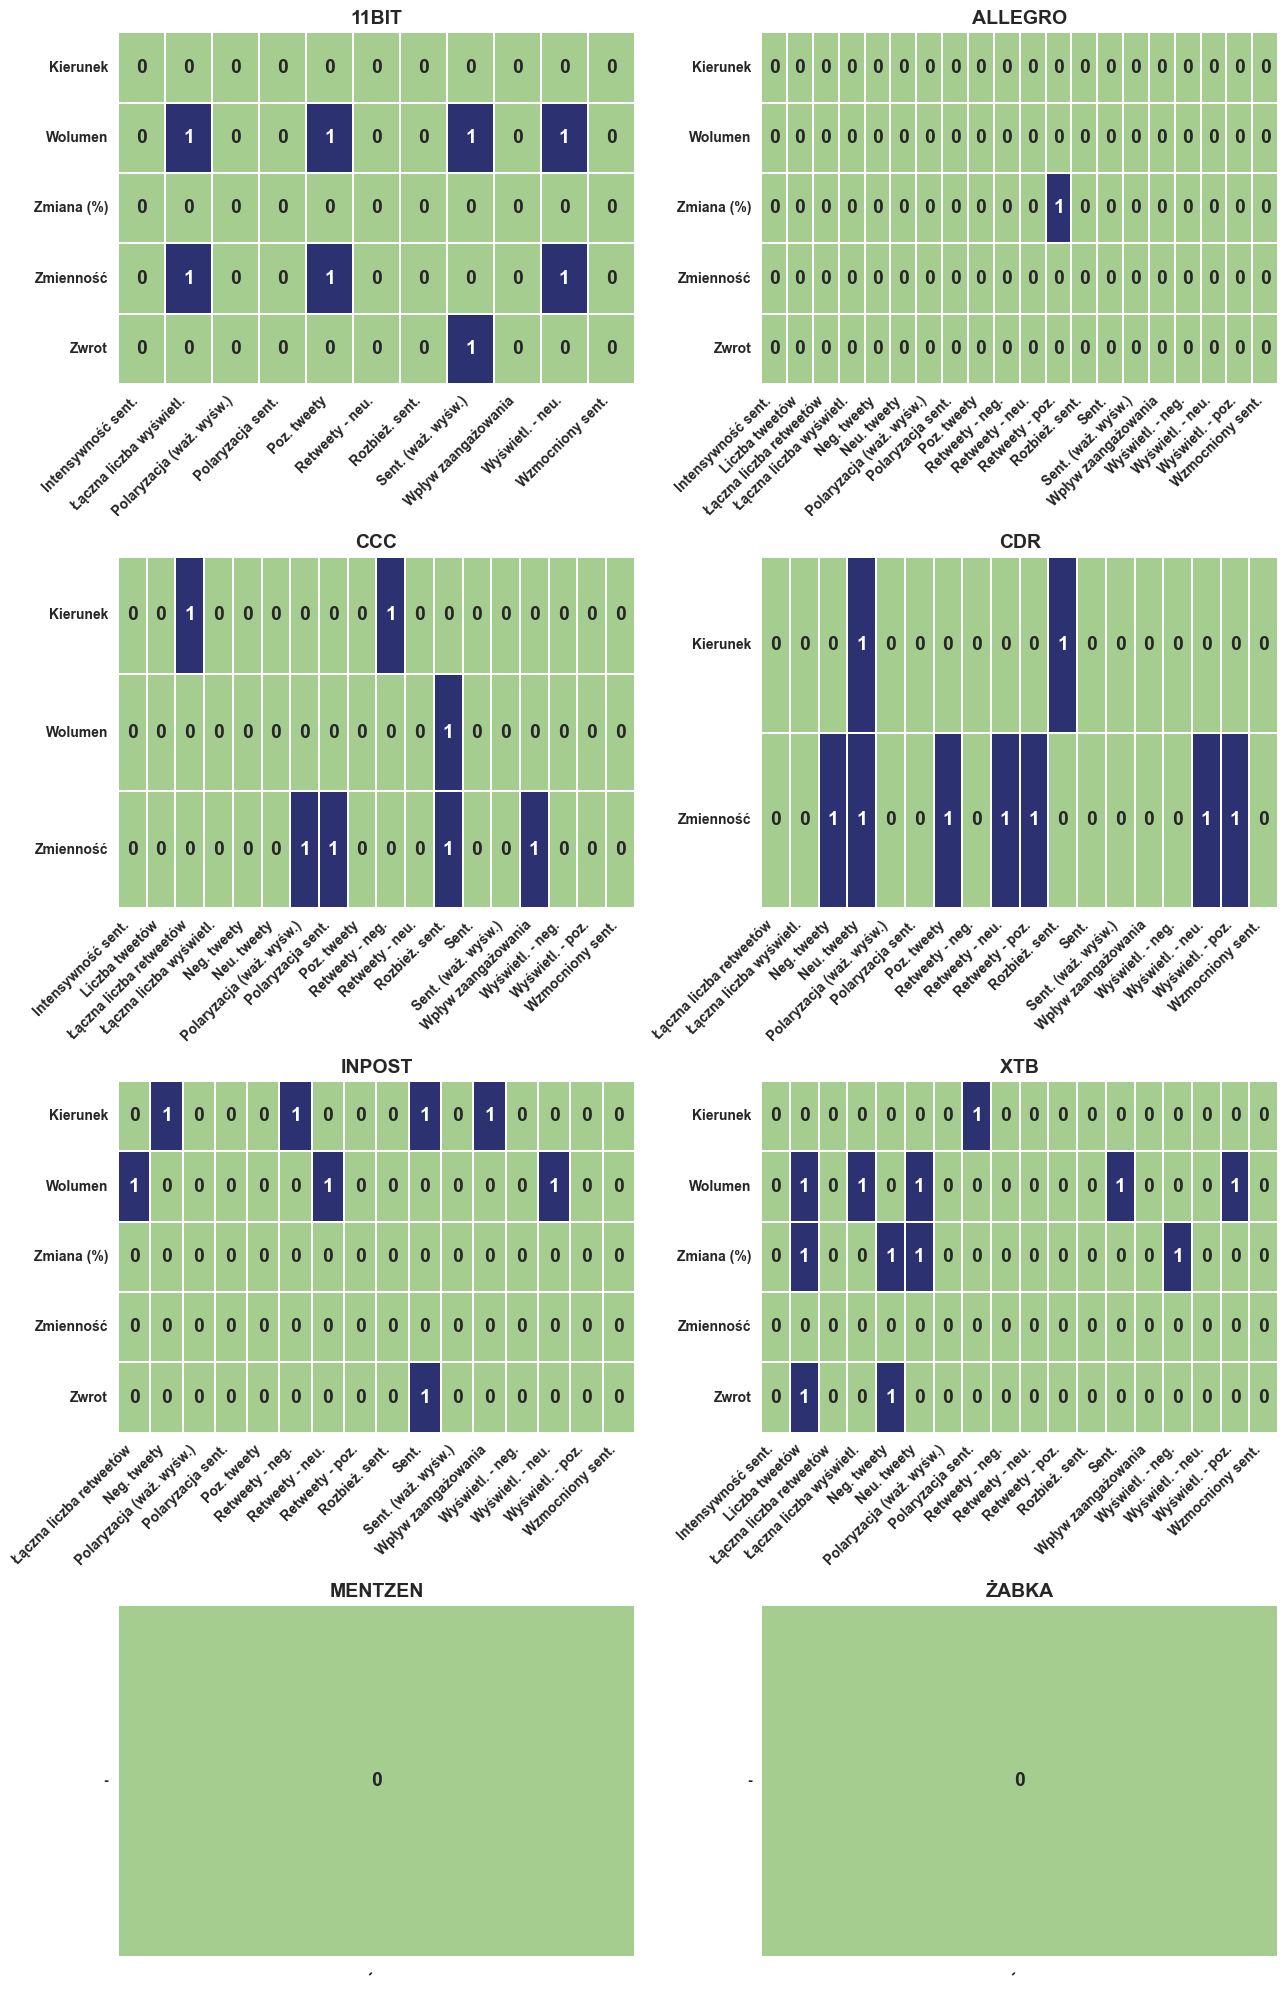

In [40]:
# Your df and column_labels_pl are assumed defined
df['Zmienne Objaśniana'] = df['Target Variable'].replace(column_labels_pl)
df['Zmienne Objaśniające'] = df['Source Feature'].replace(column_labels_pl)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
axes = axes.flatten()

max_val = 0
pivot_tables = []

for company in companies:
    # Get company data (both significant and non-significant)
    company_data = df[df['Company'] == company]
    
    # Get unique variables from company's data
    row_labels = sorted(company_data['Zmienne Objaśniana'].dropna().unique(), key=locale.strxfrm)
    col_labels = sorted(company_data['Zmienne Objaśniające'].dropna().unique(), key=locale.strxfrm)
    
    # Handle case with no variables
    if len(row_labels) == 0:
        row_labels = ["-"]
    if len(col_labels) == 0:
        col_labels = ["-"]
    
    # Create pivot table for significant relationships
    company_sig = company_data[company_data['Significant']]
    pivot_table = company_sig.pivot_table(
        index='Zmienne Objaśniana',
        columns='Zmienne Objaśniające',
        values='Lag',
        aggfunc='count',
        fill_value=0
    ).reindex(index=row_labels, columns=col_labels, fill_value=0)
    
    pivot_tables.append(pivot_table)
    
    # Update max value for color scaling
    current_max = pivot_table.max().max()
    if current_max > max_val:
        max_val = current_max

# Handle case where all values are zero
if max_val == 0:
    max_val = 1  # Prevent color scale errors

# Plot each company's heatmap
for i, company in enumerate(companies):
    ax = axes[i]
    sns.heatmap(
        pivot_tables[i],
        annot=True,
        fmt='d',
        cmap='crest',
        linewidths=0.1,
        linecolor='white',
        vmin=0,
        vmax=max_val,
        cbar=False,
        ax=ax,
        annot_kws={"fontsize": 14, "weight": "bold"}
    )
    
    ax.set_title(company, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

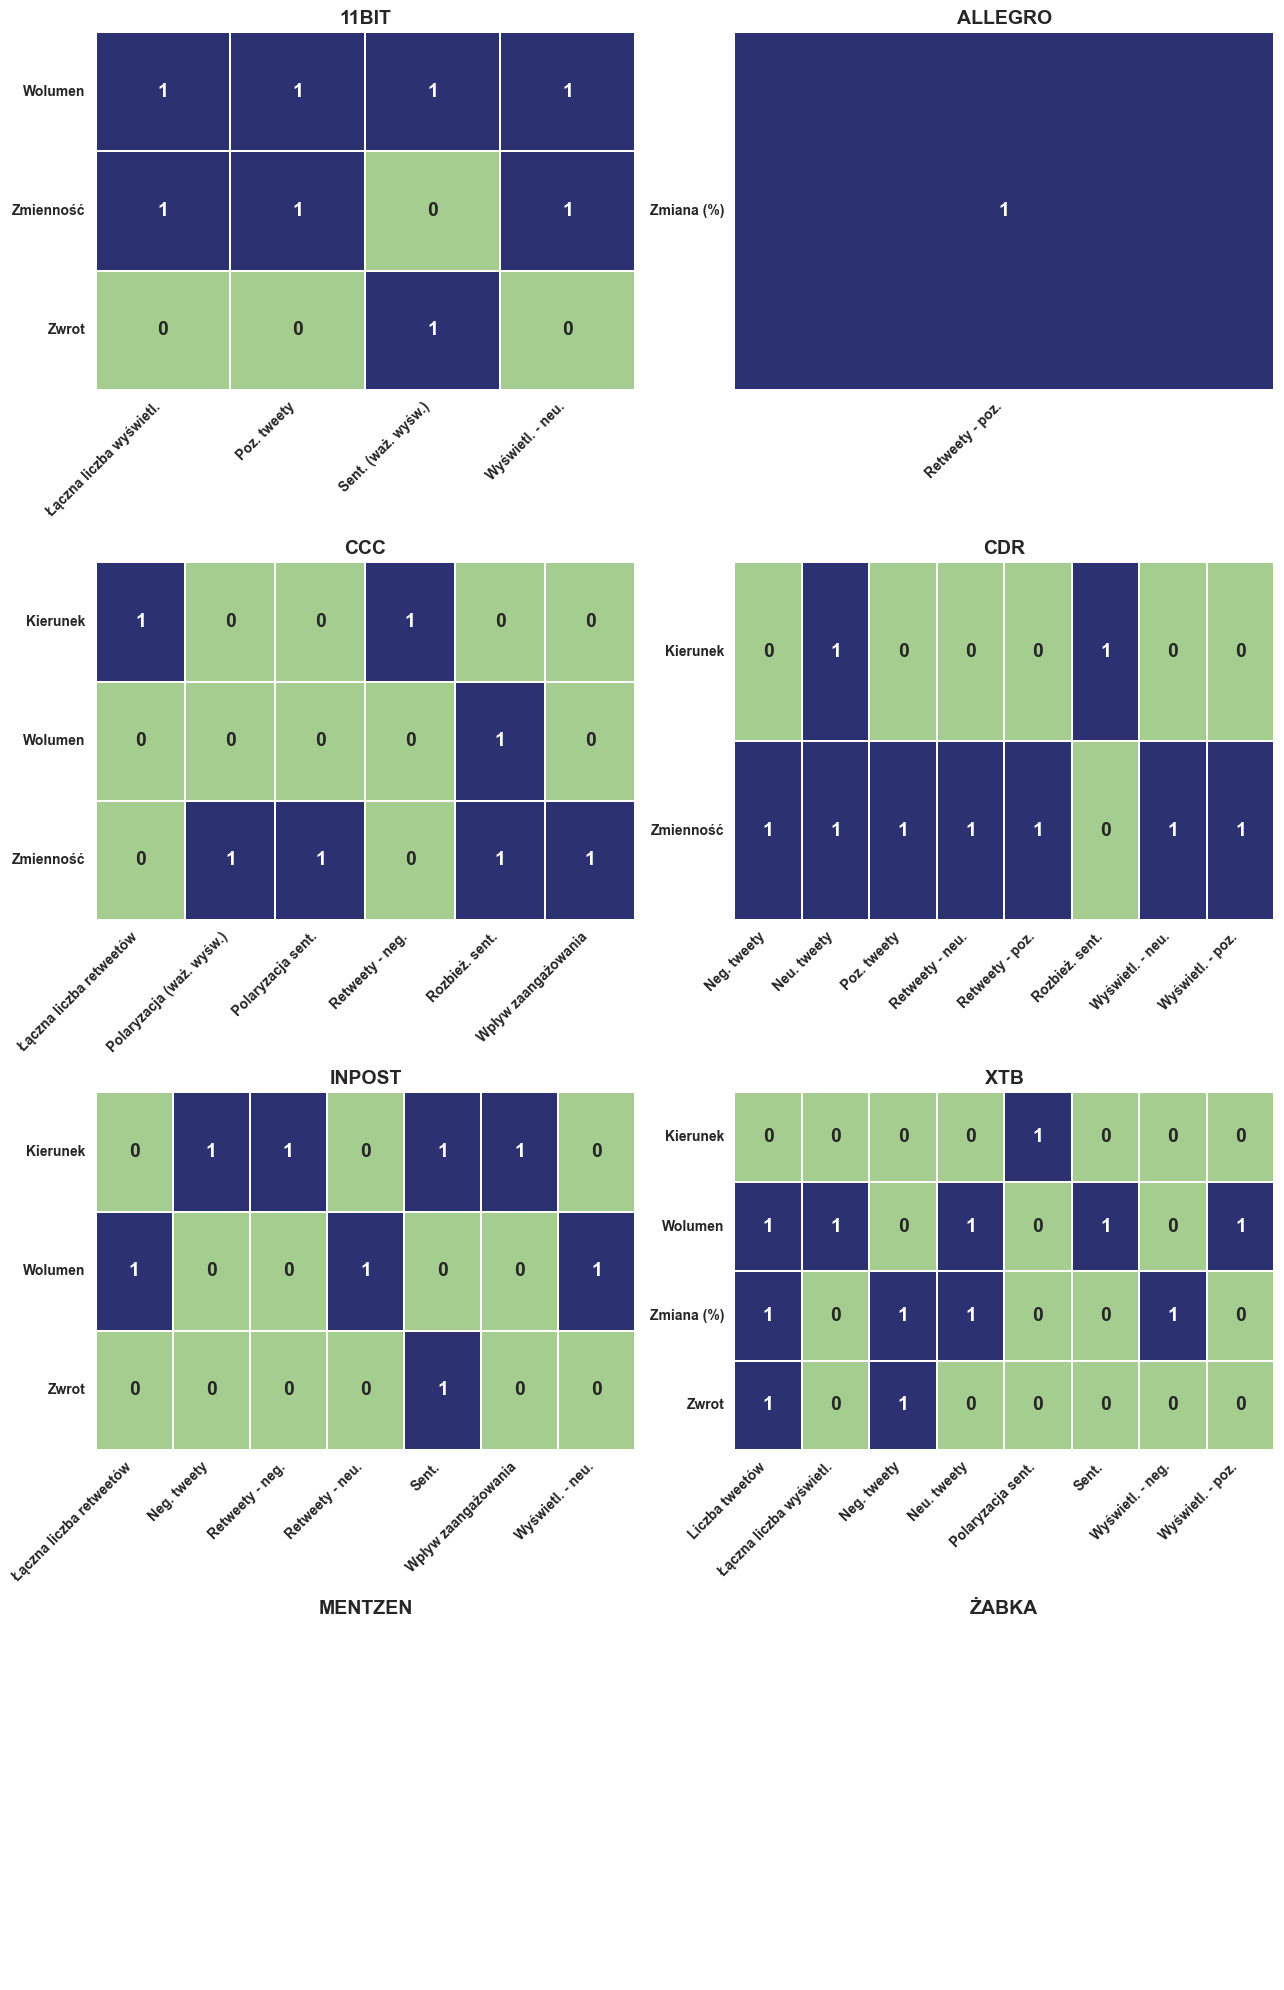

In [41]:
# Your df and column_labels_pl etc are assumed defined here
df['Zmienne Objaśniana'] = df['Target Variable'].replace(column_labels_pl)
df['Zmienne Objaśniające'] = df['Source Feature'].replace(column_labels_pl)
fix, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
axes = axes.flatten()

# Find global max value across all pivot tables to unify scale
max_val = 0
pivot_tables = []

for company in companies:
    data = df[df['Company'] == company]
    data = data[data['Significant']==True]
    significant_df = data[data['Significant']]
    pivot_table = significant_df.pivot_table(
        index='Zmienne Objaśniana',
        columns='Zmienne Objaśniające',
        values='Lag',
        aggfunc='count',
        fill_value=0
    )

    all_targets = sorted(data['Zmienne Objaśniana'].unique(), key=locale.strxfrm)
    all_features = sorted(data['Zmienne Objaśniające'].unique(), key=locale.strxfrm)
    pivot_table = pivot_table.reindex(index=all_targets, columns=all_features, fill_value=0)
    
    pivot_tables.append(pivot_table)
    
    # Handle empty pivot tables
    if pivot_table.size > 0:
        max_val = max(max_val, pivot_table.values.max())

# Set minimum max_val to 1 if all pivot tables are empty
if max_val == 0:
    max_val = 1

# Plot with unified color scale and no colorbars individually
for i, company in enumerate(companies):
    ax = axes[i]
    pivot_table = pivot_tables[i]

    sns.heatmap(
        pivot_table,
        annot=True,
        fmt='d',
        cmap='crest',
        linewidths=0.1,
        linecolor='white',
        vmin=0,
        vmax=max_val,
        cbar=False,
        ax=ax,
        annot_kws={"fontsize": 14, "weight": "bold"}  
    )

    ax.set_title(company, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [42]:
hold = 0.05
maxlag = 5
if os.path.exists('granger_boot.json'):
        with open('granger_boot.json', 'r') as f:
            granger_results_boot = json.load(f)
else:
    # New settings for bootstrap
    bootstrap_block_size = 5  # Block size for shuffling
    B = 300  # Number of bootstrap iterations
    granger_results_boot = {}
    # Iterate over each company and perform bootstrap Granger causality tests
    for company, results in stationary_columns.items():
        print(company)
        df_company = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()
        granger_results_boot[company] = {}
        for stock_var in results['STOCK']:
            granger_results_boot[company][stock_var] = {}
            print(stock_var)
            for twitter_var in results['TWITTER']:

                max_lags = granger_results.get(company, {}).get(stock_var, {}).get(twitter_var, {}).get('optimal_lags', 15)
                print(max_lags)
                block = autocorrelation_results_ord[company]['TWITTER'][twitter_var]
                if block == 0:
                    block = 1

                granger_results_boot[company][stock_var][twitter_var] = test_granger_bootstrap(df_company,
                                                                                          stock_var=stock_var,
                                                                                          twitter_var=twitter_var,
                                                                                          maxlag = max_lags,
                                                                                          B = B,
                                                                                          bootstrap_block_size = block)
                print('saved')
   

In [43]:
def flatten_granger_results_boot(granger_dict):
    rows = []
    for company, company_data in granger_dict.items():
        for target, target_data in company_data.items():
            for source, cont in target_data.items():
                for lag, p_value in cont['significant_lags'].items():
                    rows.append({
                        "Company": company,
                        "Target Variable": target,
                        "Source Feature": source,
                        "Lag": int(lag),
                        "Significant": p_value < 0.05
                    })
    return pd.DataFrame(rows)


In [44]:
res_granger_boot = flatten_granger_results_boot(granger_results_boot)

In [45]:
res_granger_boot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756 entries, 0 to 2755
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Company          2756 non-null   object
 1   Target Variable  2756 non-null   object
 2   Source Feature   2756 non-null   object
 3   Lag              2756 non-null   int64 
 4   Significant      2756 non-null   bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 88.9+ KB


In [46]:
granger_comparison = pd.merge(df_granger, res_granger_boot,
         on=['Company', 'Target Variable', 'Source Feature', 'Lag'], how='outer')
granger_comparison.rename(columns={
    'Significant_x': 'Original Significant',
    'Significant_y': 'Bootstrap Significant'
}, inplace=True)
granger_comparison.fillna('not_tested', inplace=True)


In [47]:
bootstrap_original_diff = granger_comparison.loc[(granger_comparison['Original Significant'] != 'not_tested') & (granger_comparison['Original Significant'] !=granger_comparison['Bootstrap Significant']),:].head()

In [48]:
granger_comparison = pd.merge(df_granger, res_granger_boot,
         on=['Company', 'Target Variable', 'Source Feature', 'Lag'], how='outer', suffixes=('_original', '_bootstrap'))
granger_comparison.head()
granger_comparison


Company Target Variable          Source Feature  Lag Significant_original Any Autocorrelation Any Heteroskedasticity Model Stable   Flag  Significant_bootstrap
0      11BIT          Change                Positive    1                  NaN                 NaN                    NaN          NaN    NaN                   True
1      11BIT          Change                Positive    2                  NaN                 NaN                    NaN          NaN    NaN                  False
2      11BIT          Change                Positive    3                False               False                  False         True  False                  False
3      11BIT          Change     amplified_sentiment    1                False               False                  False         True  False                  False
4      11BIT          Change       engagement_impact    1                False               False                  False         True  False                  False
...      ...             ...                     ...  ...                  ...                 ...                    ...          ...    ...                    ...
2751   ŻABKA          Return     view_count_Positive    4                  NaN                 NaN                    NaN          NaN    NaN                  False
2752   ŻABKA          Return  view_weighted_polarity    1                  NaN                 NaN                    NaN          NaN    NaN                   True
2753   ŻABKA          Return  view_weighted_polarity    2                  NaN                 NaN                    NaN          NaN    NaN                  False
2754   ŻABKA          Return  view_weighted_polarity    3                  NaN                 NaN                    NaN          NaN    NaN                  False
2755   ŻABKA          Return  view_weighted_polarity    4                  NaN                 NaN                    NaN          NaN    NaN                  False

[2756 rows x 10 columns]

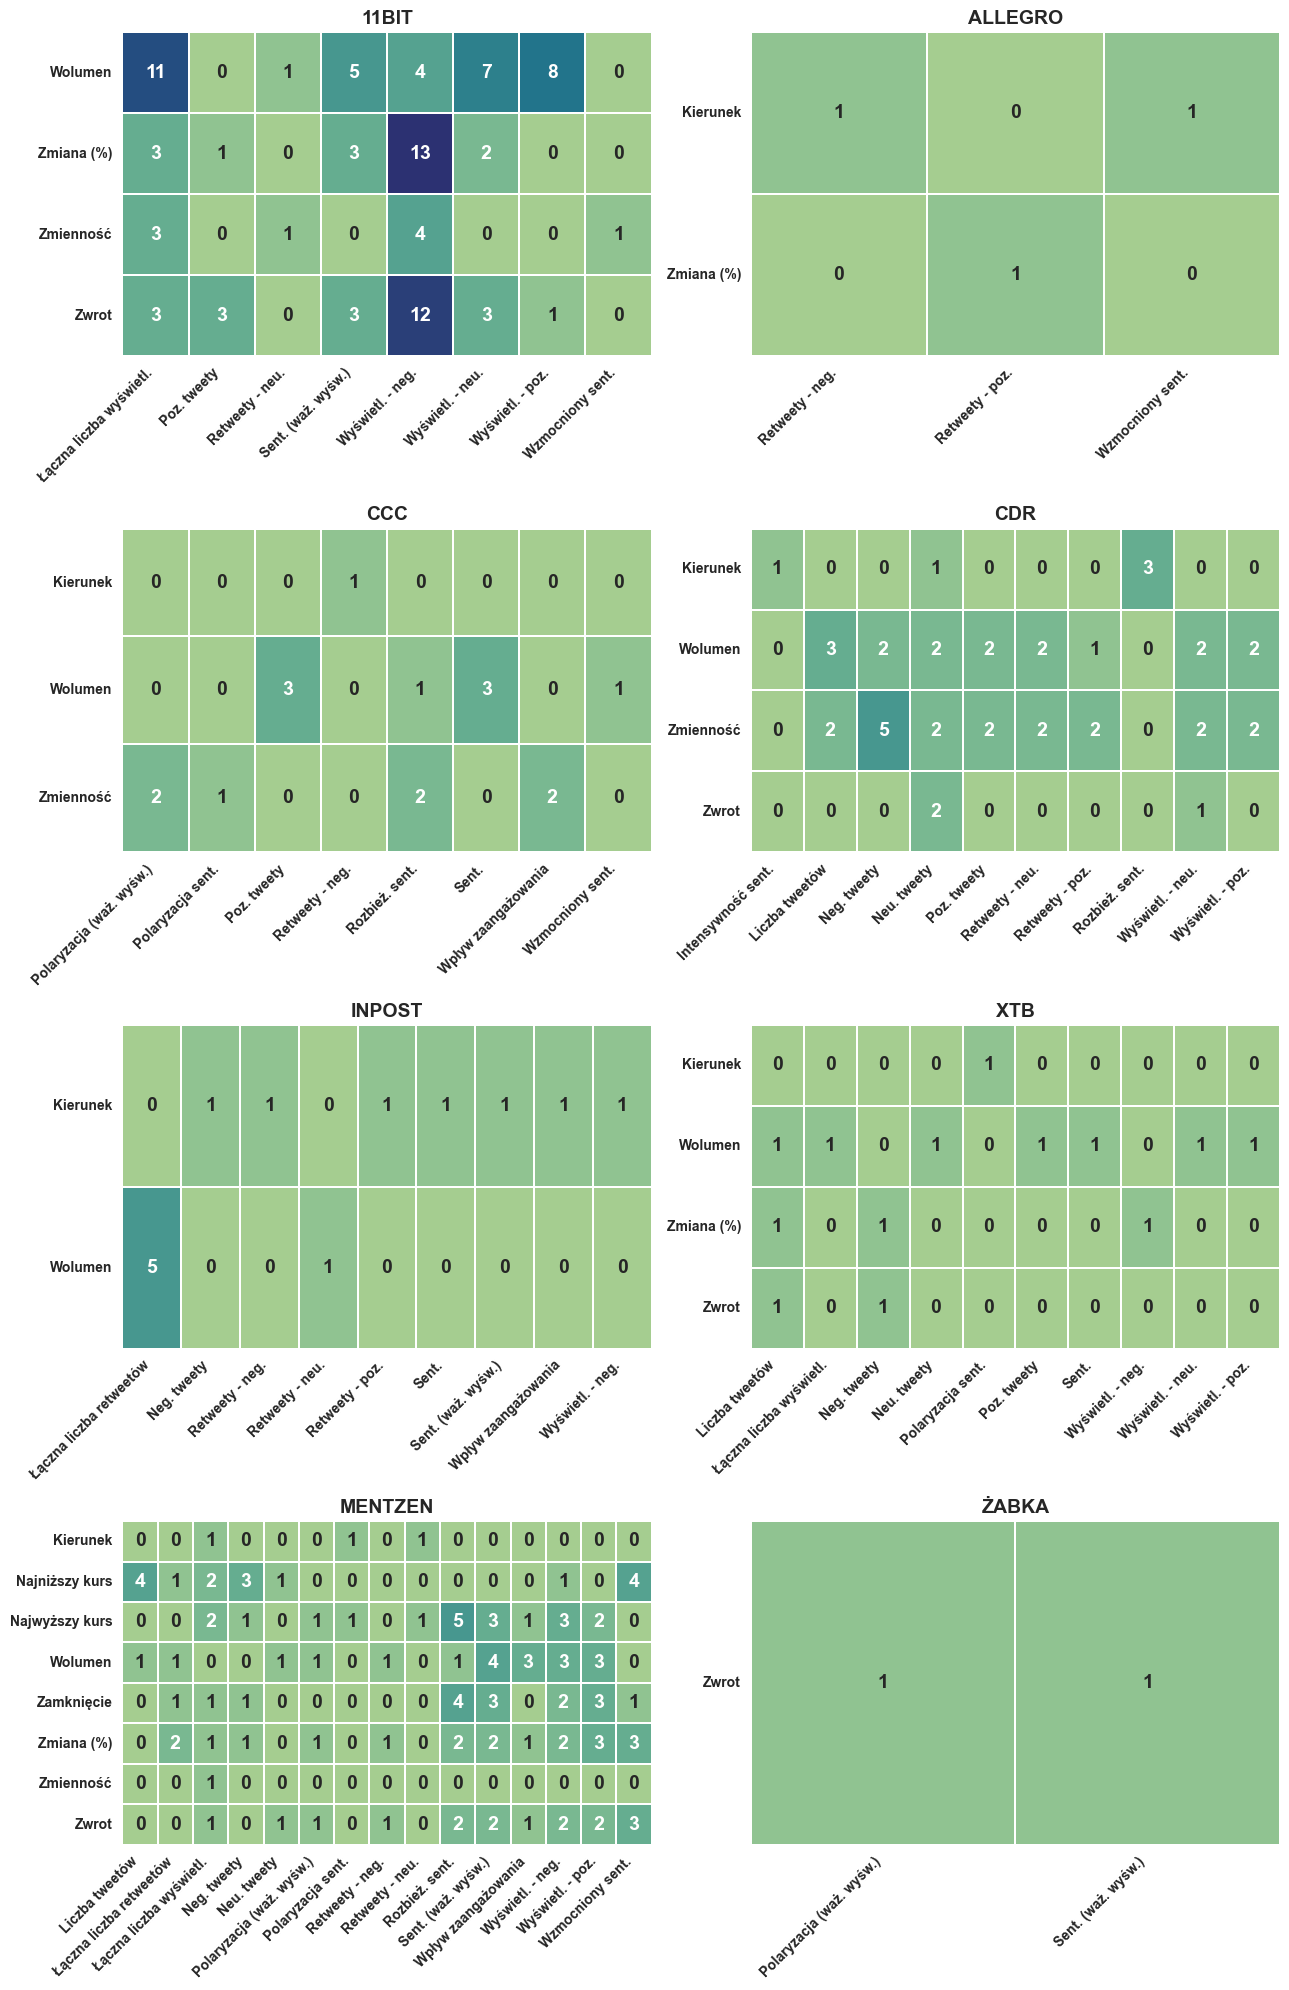

In [49]:
# Your df and column_labels_pl are assumed defined
df = granger_comparison[granger_comparison['Significant_bootstrap'] == True].copy()
df['Zmienne Objaśniana'] = df['Target Variable'].replace(column_labels_pl)
df['Zmienne Objaśniające'] = df['Source Feature'].replace(column_labels_pl)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
axes = axes.flatten()

max_val = 0
pivot_tables = []

for company in companies:
    # Get company data (both significant and non-significant)
    company_data = df[df['Company'] == company]
    
    # Get unique variables from company's data
    row_labels = sorted(company_data['Zmienne Objaśniana'].dropna().unique(), key=locale.strxfrm)
    col_labels = sorted(company_data['Zmienne Objaśniające'].dropna().unique(), key=locale.strxfrm)
    
    # Handle case with no variables
    if len(row_labels) == 0:
        row_labels = ["-"]
    if len(col_labels) == 0:
        col_labels = ["-"]
    
    # Create pivot table for significant relationships
    company_sig = company_data[company_data['Significant_bootstrap']]
    pivot_table = company_sig.pivot_table(
        index='Zmienne Objaśniana',
        columns='Zmienne Objaśniające',
        values='Lag',
        aggfunc='count',
        fill_value=0
    ).reindex(index=row_labels, columns=col_labels, fill_value=0)
    
    pivot_tables.append(pivot_table)
    
    # Update max value for color scaling
    current_max = pivot_table.max().max()
    if current_max > max_val:
        max_val = current_max

# Handle case where all values are zero
if max_val == 0:
    max_val = 1  # Prevent color scale errors

# Plot each company's heatmap
for i, company in enumerate(companies):
    ax = axes[i]
    sns.heatmap(
        pivot_tables[i],
        annot=True,
        fmt='d',
        cmap='crest',
        linewidths=0.1,
        linecolor='white',
        vmin=0,
        vmax=max_val,
        cbar=False,
        ax=ax,
        annot_kws={"fontsize": 14, "weight": "bold"}
    )
    
    ax.set_title(company, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Dictionary of variables to drop per company
columns_to_drop = {
    '11BIT': ['view_count_Neutral','engagement_impact'],
    'ALLEGRO': ['Neutral',''],
    'CCC': ['view_weighted_polarity'],
    'CDR': ['tweet_volume', 'view_weighted_polarity'],
    'INPOST': ['tweet_volume', 'view_weighted_polarity'],
    'XTB': ['tweet_volume', 'retweet_count_Positive', 'view_weighted_polarity'],
    'MENTZEN': ['view_count_Positive', 'retweet_count_Positive', 'sentiment_score_views',
                'retweet_count_Neutral', 'total_retweet_count', 'sentiment_intensity', 'view_weighted_polarity'],
    'ŻABKA': ['tweet_volume']
}
columns_to_drop

corr_per_company = {}
for company in companies:
    print(company)
    df = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company]

    stationary_columns_curr = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
    cols_to_drop = columns_to_drop.get(company, [])
    df_corr = df[stationary_columns_curr].corr()
    df_corr.reset_index(inplace=True)
    df_corr_melted = pd.melt(df_corr,'index')

    df_corr_melted = df_corr_melted[~((df_corr_melted['index'].isin(cols_to_drop)) | (df_corr_melted['variable'].isin(cols_to_drop)))]
    corr_per_company[company] = df_corr_melted[(df_corr_melted['value']>=0.9) & (df_corr_melted['value']<1) ]
    pprint.pprint(corr_per_company[company])

11BIT
Empty DataFrame
Columns: [index, variable, value]
Index: []
ALLEGRO
                      index                variable     value
6       total_retweet_count                Negative  0.916771
7    retweet_count_Negative                Negative  0.924373
10             tweet_volume                Negative  0.986424
67   retweet_count_Negative     view_count_Negative  0.912548
120                Negative     total_retweet_count  0.916771
127  retweet_count_Negative     total_retweet_count  0.973852
140                Negative  retweet_count_Negative  0.924373
143     view_count_Negative  retweet_count_Negative  0.912548
146     total_retweet_count  retweet_count_Negative  0.973852
200                Negative            tweet_volume  0.986424
237     amplified_sentiment         sentiment_score  0.977990
319       engagement_impact  view_weighted_polarity  0.990409
351         sentiment_score     amplified_sentiment  0.977990
395  view_weighted_polarity       engagement_impact  0.990

### Non - linear modelling

In [ ]:
# Configuration
RESULTS_FILE = 'granger_results_lstm.pkl'
TEMP_DIR = 'temp_results'
os.makedirs(TEMP_DIR, exist_ok=True)

# Load existing results if available
try:
    granger_results_lstm = joblib.load(RESULTS_FILE)
    print(f"Loaded existing results with {len(granger_results_lstm)} companies")
except:
    granger_results_lstm = {}
    print("Starting new results file")

# Early stopping configuration
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

# Model checkpointing
checkpoint = ModelCheckpoint(
    filepath=os.path.join(TEMP_DIR, 'best_model.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=0
)

for company, results in stationary_columns.items():
    # Skip already processed companies
    if company in granger_results_lstm:
        print(f"Skipping already processed company: {company}")
        continue
        
    print(f"\n{'='*50}\nProcessing company: {company}\n{'='*50}")
    df_company = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company].copy()
    df_company = df_company.sort_index()
    
    # Initialize company entry with timestamp
    granger_results_lstm[company] = {
        'start_time': str(pd.Timestamp.now()),
        'stock_vars': {}
    }
    
    for stock_var in results['STOCK']:
        granger_results_lstm[company]['stock_vars'][stock_var] = {
            'twitter_vars': {},
            'completed': False
        }
        
        for twitter_var in results['TWITTER']:
            print(f"\n  Testing: {stock_var} <- {twitter_var}")
            
            # Skip already processed pairs
            if twitter_var in granger_results_lstm[company]['stock_vars'][stock_var]['twitter_vars']:
                print(f"    Skipping already processed pair")
                continue
                
            try:
                # ... [data preparation code remains the same] ...
                print(f"Twitter variable: {twitter_var}")
                max_lags = granger_results.get(company, {}).get(stock_var, {}).get(twitter_var, {}).get('optimal_lags', 15)
                max_lags = int(max_lags)
                print(f"Max lags: {max_lags}")
                # Create dataset with correct column order [STOCK, TWEET]
                data = df_company[[stock_var, twitter_var]].copy()
                # Temporal split (preserve order)
                
                data_train_scaled, data_valid_scaled, data_test_scaled, _ = simple_train_valid_test_split_standardized(data, train_ratio=0.6, valid_ratio=0.2)    
  
                # Run causality test with robust callbacks
                results_cas = nonlincausality.nonlincausalityNN(
                    x=data_train_scaled.values,
                    maxlag=max_lags,
                    NN_config=['d', 'dr', 'd'],
                    NN_neurons=[8, 0.3, 4],
                    x_test=data_test_scaled.values,
                    run=3,
                    epochs_num=[50, 30],  # Increased to allow early stopping
                    learning_rate=[0.005, 0.0005],
                    batch_size_num=16,
                    x_val=data_valid_scaled.values,
                    regularization='l1_l2',
                    reg_alpha=[0.005, 0.005],
                    callbacks=[early_stop, checkpoint],  # ADDED CALLBACKS
                    verbose=False,
                    plot=False
                )
                
                # Store results immediately after successful run
                pair_results = {
                    'lags': {}
                    
                }
                
                for lag, res_obj in results_cas.items():
                    pair_results['lags'][lag] = {
                        'p_value': res_obj.p_value,
                        'test_statistic': res_obj.test_statistic,
                        'RSS_X': res_obj.RSS_X_all,
                        'RSS_XY': res_obj.RSS_XY_all,
                    }
                
                # Save to main results structure
                granger_results_lstm[company]['stock_vars'][stock_var]['twitter_vars'][twitter_var] = pair_results
                
                # Incremental save after each pair
                temp_path = os.path.join(TEMP_DIR, f'temp_{company}.pkl')
                joblib.dump(granger_results_lstm, temp_path)
                shutil.move(temp_path, RESULTS_FILE)  # Atomic replace
                print(f"✅ Saved results for {stock_var}-{twitter_var}")
                
            except Exception as e:
                error_msg = f"Failed for {stock_var}-{twitter_var}: {str(e)}"
                print(error_msg)
                granger_results_lstm[company]['stock_vars'][stock_var]['twitter_vars'][twitter_var] = {
                    'error': error_msg,
                    'timestamp': str(pd.Timestamp.now())
                }
                joblib.dump(granger_results_lstm, RESULTS_FILE)
        
        # Mark stock_var as completed
        granger_results_lstm[company]['stock_vars'][stock_var]['completed'] = True
        granger_results_lstm[company]['end_time'] = str(pd.Timestamp.now())
        joblib.dump(granger_results_lstm, RESULTS_FILE)
    
    print(f"\n{'='*50}\nCompleted company: {company}\n{'='*50}")

print("\nProcessing completed successfully!")

Loaded existing results with 7 companies
Skipping already processed company: 11BIT
Skipping already processed company: ALLEGRO
Skipping already processed company: CCC
Skipping already processed company: CDR
Skipping already processed company: INPOST
Skipping already processed company: XTB
Skipping already processed company: MENTZEN

Processing company: ŻABKA

  Testing: Return <- Negative
Twitter variable: Negative
Max lags: 15



Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 1.
1/1 [==============================] - 0s 77ms/step
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 9: ear

In [4]:
with open('granger_results_lstm.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
data

{'11BIT': {'start_time': '2025-06-29 17:51:58.063806',
  'stock_vars': {'Wolumen': {'twitter_vars': {'Positive': {'lags': {1: {'p_value': 0.0012427025649230927,
        'test_statistic': 602.0,
        'RSS_X': [7834.507612422407, 7794.6829335996335, 7777.168487688303],
        'RSS_XY': [11150.078506819174, 9297.79253556148, 6584.0569279821875]},
       2: {'p_value': 0.995218043019122,
        'test_statistic': 195.0,
        'RSS_X': [7183.980165234562, 7530.134732861191, 10117.946902015092],
        'RSS_XY': [11334.667781009748, 8940.570060912733, 7611.213354344887]},
       3: {'p_value': 0.34910284451325424,
        'test_statistic': 378.0,
        'RSS_X': [8251.545556817378, 8032.695318367069, 10796.06253673884],
        'RSS_XY': [7993.415305174713, 7927.303863918036, 9087.757170313795]}}},
     'view_count_Negative': {'lags': {1: {'p_value': 0.27858097113858094,
        'test_statistic': 433.0,
        'RSS_X': [8156.658181548911, 7325.3905085089855, 11299.451989024794],
   

In [6]:
rows = []
for company, company_data in data.items():
        start_time = company_data.get('start_time')
        stock_vars = company_data.get('stock_vars', {})

        for stock_var, stock_data in stock_vars.items():
            twitter_vars = stock_data.get('twitter_vars', {})
            for twitter_var, twitter_data in twitter_vars.items():
                lags = twitter_data.get('lags', {})
                for lag, lag_data in lags.items():
                    row = {
                        'company': company,
                        'start_time': start_time,
                        'stock_var': stock_var,
                        'twitter_var': twitter_var,
                        'lag': lag,
                        'p_value': lag_data.get('p_value'),
                        'test_statistic': lag_data.get('test_statistic')
                    }

                    # Expand RSS_X and RSS_XY arrays
                    for i, val in enumerate(lag_data.get('RSS_X', [])):
                        row[f'RSS_X_{i}'] = val
                    for i, val in enumerate(lag_data.get('RSS_XY', [])):
                        row[f'RSS_XY_{i}'] = val

                    rows.append(row)

In [26]:
rows

[{'company': '11BIT',
  'start_time': '2025-06-29 17:51:58.063806',
  'stock_var': 'Wolumen',
  'twitter_var': 'Positive',
  'lag': 1,
  'p_value': 0.0012427025649230927,
  'test_statistic': 602.0,
  'RSS_X_0': 7834.507612422407,
  'RSS_X_1': 7794.6829335996335,
  'RSS_X_2': 7777.168487688303,
  'RSS_XY_0': 11150.078506819174,
  'RSS_XY_1': 9297.79253556148,
  'RSS_XY_2': 6584.0569279821875},
 {'company': '11BIT',
  'start_time': '2025-06-29 17:51:58.063806',
  'stock_var': 'Wolumen',
  'twitter_var': 'Positive',
  'lag': 2,
  'p_value': 0.995218043019122,
  'test_statistic': 195.0,
  'RSS_X_0': 7183.980165234562,
  'RSS_X_1': 7530.134732861191,
  'RSS_X_2': 10117.946902015092,
  'RSS_XY_0': 11334.667781009748,
  'RSS_XY_1': 8940.570060912733,
  'RSS_XY_2': 7611.213354344887},
 {'company': '11BIT',
  'start_time': '2025-06-29 17:51:58.063806',
  'stock_var': 'Wolumen',
  'twitter_var': 'Positive',
  'lag': 3,
  'p_value': 0.34910284451325424,
  'test_statistic': 378.0,
  'RSS_X_0': 825

In [7]:
granger_mlp = pd.DataFrame(rows)

In [25]:
granger_mlp

company                  start_time stock_var             twitter_var  \
0     11BIT  2025-06-29 17:51:58.063806   Wolumen                Positive   
1     11BIT  2025-06-29 17:51:58.063806   Wolumen                Positive   
2     11BIT  2025-06-29 17:51:58.063806   Wolumen                Positive   
3     11BIT  2025-06-29 17:51:58.063806   Wolumen     view_count_Negative   
4     11BIT  2025-06-29 17:51:58.063806   Wolumen     view_count_Negative   
..      ...                         ...       ...                     ...   
891     XTB  2025-06-29 21:50:28.722942    Change  view_weighted_polarity   
892     XTB  2025-06-29 21:50:28.722942    Change     sentiment_intensity   
893     XTB  2025-06-29 21:50:28.722942    Change     amplified_sentiment   
894     XTB  2025-06-29 21:50:28.722942    Change    sentiment_divergence   
895     XTB  2025-06-29 21:50:28.722942    Change       engagement_impact   

     lag   p_value  test_statistic      RSS_X_0      RSS_X_1       RSS_X_2  \
0      1  0.001243           602.0  7834.507612  7794.682934   7777.168488   
1      2  0.995218           195.0  7183.980165  7530.134733  10117.946902   
2      3  0.349103           378.0  8251.545557  8032.695318  10796.062537   
3      1  0.278581           433.0  8156.658182  7325.390509  11299.451989   
4      2  0.039602           492.0  6949.083725  8512.896102  11111.735506   
..   ...       ...             ...          ...          ...           ...   
891    1  0.539259           603.0    23.753924    23.495034     23.969725   
892    1  0.678517           566.0    24.051347    23.886180     23.566305   
893    1  0.232524           687.0    23.817107    24.082548     23.829242   
894    1  0.472496           620.0    23.652658    23.415263     23.437765   
895    1  0.779406           535.0    23.880046    23.757794     23.801551   

         RSS_XY_0     RSS_XY_1     RSS_XY_2  
0    11150.078507  9297.792536  6584.056928  
1    11334.667781  8940.570061  7611.213354  
2     7993.415305  7927.303864  9087.757170  
3     7504.936747  7406.834031  7272.692979  
4    10481.543327  6680.223432  7220.376788  
..            ...          ...          ...  
891     23.817790    22.976169    23.429826  
892     24.613661    23.843104    24.613088  
893     24.748015    26.729328    29.726858  
894     22.966394    22.828056    21.849705  
895     23.438171    23.522561    23.621370  

[896 rows x 13 columns]

In [9]:
granger_mlp_significant = granger_mlp[granger_mlp['p_value']<= 0.05]

In [32]:
granger_mlp_significant

company                  start_time  stock_var             twitter_var  \
75    11BIT  2025-06-29 17:51:58.063806    Wolumen       engagement_impact   
676  INPOST  2025-06-29 21:00:59.580385    Wolumen     total_retweet_count   
29    11BIT  2025-06-29 17:51:58.063806    Wolumen     view_count_Positive   
33    11BIT  2025-06-29 17:51:58.063806    Wolumen     view_count_Positive   
673  INPOST  2025-06-29 21:00:59.580385    Wolumen     total_retweet_count   
..      ...                         ...        ...                     ...   
53    11BIT  2025-06-29 17:51:58.063806    Wolumen             total_views   
0     11BIT  2025-06-29 17:51:58.063806    Wolumen                Positive   
64    11BIT  2025-06-29 17:51:58.063806    Wolumen  view_weighted_polarity   
147   11BIT  2025-06-29 17:51:58.063806  Direction     view_count_Negative   
790     XTB  2025-06-29 21:50:28.722942    Wolumen                Positive   

     lag       p_value  test_statistic       RSS_X_0      RSS_X_1  \
75     1  1.861728e-02           539.0  24610.235309  7532.219398   
676    8  6.117796e-08           870.0     12.326181    11.946251   
29     7  7.907569e-05           481.0  14634.903123  9812.084828   
33    11  3.987975e-02           299.0  11646.783777  8718.150551   
673    5  5.039259e-07           956.0     14.075914    13.043091   
..   ...           ...             ...           ...          ...   
53     7  5.205557e-03           422.0   9924.637844  7207.069687   
0      1  1.242703e-03           602.0   7834.507612  7794.682934   
64     2  1.367954e-02           522.0   7843.475799  7355.357691   
147    1  3.917297e-03           578.0     37.715306    38.346738   
790    1  4.846422e-02           780.0      9.731580    10.018475   

          RSS_X_2      RSS_XY_0      RSS_XY_1     RSS_XY_2 Zmienne Objaśniana  \
75    7527.548526   7104.627146   6986.340299  6711.106609            Wolumen   
676     12.382535      5.755413      8.613055     8.621073            Wolumen   
29   11155.890480   8074.315754   7241.197238  7654.831549            Wolumen   
33   11140.012996   6896.016013   6085.899375  7391.934223            Wolumen   
673     15.411682      9.853549      9.352498     8.701766            Wolumen   
..            ...           ...           ...          ...                ...   
53    7518.642451   9334.736237  11299.598931  6973.027965            Wolumen   
0     7777.168488  11150.078507   9297.792536  6584.056928            Wolumen   
64    7672.968919  10830.903047  11402.830657  6605.579554            Wolumen   
147     38.691195     37.238056     35.153190    75.850395           Kierunek   
790      9.084560      9.029595     22.329632    15.289784            Wolumen   

         Zmienne Objaśniające  significant  RSS_diff  
75        Wpływ zaangażowania         True  0.475622  
676   Łączna liczba retweetów         True  0.372812  
29           Wyświetl. - poz.         True  0.354818  
33           Wyświetl. - poz.         True  0.353313  
673   Łączna liczba retweetów         True  0.343819  
..                        ...          ...       ...  
53    Łączna liczba wyświetl.         True -0.119958  
0                 Poz. tweety         True -0.154897  
64   Polaryzacja (waż. wyśw.)         True -0.260911  
147          Wyświetl. - neg.         True -0.291830  
790               Poz. tweety         True -0.617813  

[94 rows x 17 columns]

In [27]:
rss_x_cols = ['RSS_X_0', 'RSS_X_1', 'RSS_X_2']
rss_xy_cols = ['RSS_XY_0', 'RSS_XY_1', 'RSS_XY_2']

numerator = granger_mlp_significant[rss_x_cols].sum(axis=1) - granger_mlp_significant[rss_xy_cols].sum(axis=1)
denominator = granger_mlp_significant[rss_x_cols].sum(axis=1)

granger_mlp_significant['RSS_diff'] = numerator / denominator


In [30]:
granger_mlp_significant.sort_values(by='RSS_diff', ascending=False).head(20)

company                  start_time   stock_var             twitter_var  \
75    11BIT  2025-06-29 17:51:58.063806     Wolumen       engagement_impact   
676  INPOST  2025-06-29 21:00:59.580385     Wolumen     total_retweet_count   
29    11BIT  2025-06-29 17:51:58.063806     Wolumen     view_count_Positive   
33    11BIT  2025-06-29 17:51:58.063806     Wolumen     view_count_Positive   
673  INPOST  2025-06-29 21:00:59.580385     Wolumen     total_retweet_count   
52    11BIT  2025-06-29 17:51:58.063806     Wolumen             total_views   
48    11BIT  2025-06-29 17:51:58.063806     Wolumen             total_views   
63    11BIT  2025-06-29 17:51:58.063806     Wolumen  view_weighted_polarity   
6     11BIT  2025-06-29 17:51:58.063806     Wolumen     view_count_Negative   
42    11BIT  2025-06-29 17:51:58.063806     Wolumen   sentiment_score_views   
686  INPOST  2025-06-29 21:00:59.580385     Wolumen   retweet_count_Neutral   
667  INPOST  2025-06-29 21:00:59.580385     Wolumen      view_count_Neutral   
675  INPOST  2025-06-29 21:00:59.580385     Wolumen     total_retweet_count   
49    11BIT  2025-06-29 17:51:58.063806     Wolumen             total_views   
73    11BIT  2025-06-29 17:51:58.063806     Wolumen    sentiment_divergence   
682  INPOST  2025-06-29 21:00:59.580385     Wolumen   retweet_count_Neutral   
136   11BIT  2025-06-29 17:51:58.063806  volatility             total_views   
44    11BIT  2025-06-29 17:51:58.063806     Wolumen   sentiment_score_views   
17    11BIT  2025-06-29 17:51:58.063806     Wolumen      view_count_Neutral   
685  INPOST  2025-06-29 21:00:59.580385     Wolumen   retweet_count_Neutral   

     lag       p_value  test_statistic       RSS_X_0       RSS_X_1  \
75     1  1.861728e-02           539.0  24610.235309   7532.219398   
676    8  6.117796e-08           870.0     12.326181     11.946251   
29     7  7.907569e-05           481.0  14634.903123   9812.084828   
33    11  3.987975e-02           299.0  11646.783777   8718.150551   
673    5  5.039259e-07           956.0     14.075914     13.043091   
52     6  4.065153e-03           450.0  10929.831365   9663.876834   
48     2  2.467659e-03           561.0  11158.129963  10653.003712   
63     1  6.045788e-03           568.0  11155.115979   7278.547597   
6      4  1.048013e-02           479.0   7935.867000  11105.161860   
42     1  1.107894e-02           553.0   7178.129141  11165.740772   
686    8  1.685976e-10           918.0     11.286970     12.707473   
667    7  4.311005e-10           951.0     13.335909     12.441406   
675    7  2.574780e-09           937.0     12.644986     12.249776   
49     3  4.585820e-03           522.0   9325.617882   8431.677200   
73     2  8.111967e-05           619.0  11623.364262   8111.182367   
682    4  3.519133e-09          1053.0     10.739015     14.427362   
136    3  1.073172e-02           503.0    164.809960    157.065224   
44     3  3.210349e-04           570.0  14322.712105   8675.368639   
17     2  5.471479e-03           544.0   7318.286161   8304.996303   
685    7  5.151037e-09           931.0     13.242987     11.539120   

          RSS_X_2     RSS_XY_0      RSS_XY_1     RSS_XY_2 Zmienne Objaśniana  \
75    7527.548526  7104.627146   6986.340299  6711.106609            Wolumen   
676     12.382535     5.755413      8.613055     8.621073            Wolumen   
29   11155.890480  8074.315754   7241.197238  7654.831549            Wolumen   
33   11140.012996  6896.016013   6085.899375  7391.934223            Wolumen   
673     15.411682     9.853549      9.352498     8.701766            Wolumen   
52    9932.300167  7858.482839   7029.821069  6349.251975            Wolumen   
48    7938.638491  6404.760411   6873.490528  8022.447141            Wolumen   
63    8757.475995  6572.952291   6675.305351  7089.348426            Wolumen   
6    12157.112090  8441.139472   7802.389872  7995.226276            Wolumen   
42    7395.466534  7022.967646   6918.604203  6425.995445            Wolu

In [70]:
test_specific_pair( companies_data_daily_final_full[companies_data_daily_final_full['company']=='INPOST'], 'Wolumen','retweet_count_Neutral',8)


Testing causality: Wolumen <- retweet_count_Neutral
Data shape: (255, 2), Time range: 1 to 362
Using max lags: 8


NameError: name 'StandardScaler' is not defined

In [ ]:
def test_specific_pair(df, stock_var, twitter_var, max_lags=15):
    """
    Test causality between stock and twitter variables in a DataFrame
    :param df: DataFrame containing the time series data
    :param stock_var: Name of the stock variable column
    :param twitter_var: Name of the twitter variable column
    :param max_lags: Number of lags to use for the test (default=15)
    """
    # Prepare data - sort by index and select relevant columns
    data = df[[stock_var, twitter_var]].copy().sort_index()
    
    print(f"\n{'='*50}")
    print(f"Testing causality: {stock_var} <- {twitter_var}")
    print(f"Data shape: {data.shape}, Time range: {data.index.min()} to {data.index.max()}")
    print(f"Using max lags: {max_lags}")
    print(f"{'='*50}")
    
    # Split and standardize data
    data_train_scaled, data_valid_scaled, data_test_scaled, _ = simple_train_valid_test_split_standardized(
        data, train_ratio=0.6, valid_ratio=0.2
    )

    # Configure callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1
    )
    
    checkpoint = ModelCheckpoint(
        filepath=f'best_model_{stock_var}_{twitter_var}.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        verbose=0
    )

    # Run causality test
    results_cas = nonlincausality.nonlincausalityNN(
        x=data_train_scaled.values,
        maxlag=max_lags,
        NN_config=['d', 'dr', 'd'],
        NN_neurons=[8, 0.3, 4],
        x_test=data_test_scaled.values,
        run=3,
        epochs_num=[50, 30],
        learning_rate=[0.005, 0.0005],
        batch_size_num=16,
        x_val=data_valid_scaled.values,
        regularization='l1_l2',
        reg_alpha=[0.005, 0.005],
        callbacks=[early_stop, checkpoint],
        verbose=False,
        plot=False
    )
    
    # Prepare results
    pair_results = {
        'stock_var': stock_var,
        'twitter_var': twitter_var,
        'max_lags': max_lags,
        'lags': {}
    }
    
    for lag, res_obj in results_cas.items():
        pair_results['lags'][lag] = {
            'p_value': res_obj.p_value,
            'test_statistic': res_obj.test_statistic,
            'RSS_X': res_obj.RSS_X_all,
            'RSS_XY': res_obj.RSS_XY_all,
        }
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"Results for {stock_var} <- {twitter_var}:")
    for lag in range(1, max_lags + 1):
        if lag in pair_results['lags']:
            res = pair_results['lags'][lag]
            print(f"Lag {lag}: p-value={res['p_value']:.4f}, test_stat={res['test_statistic']:.4f}")
    print(f"{'='*50}")
    
    return pair_results, results_cas

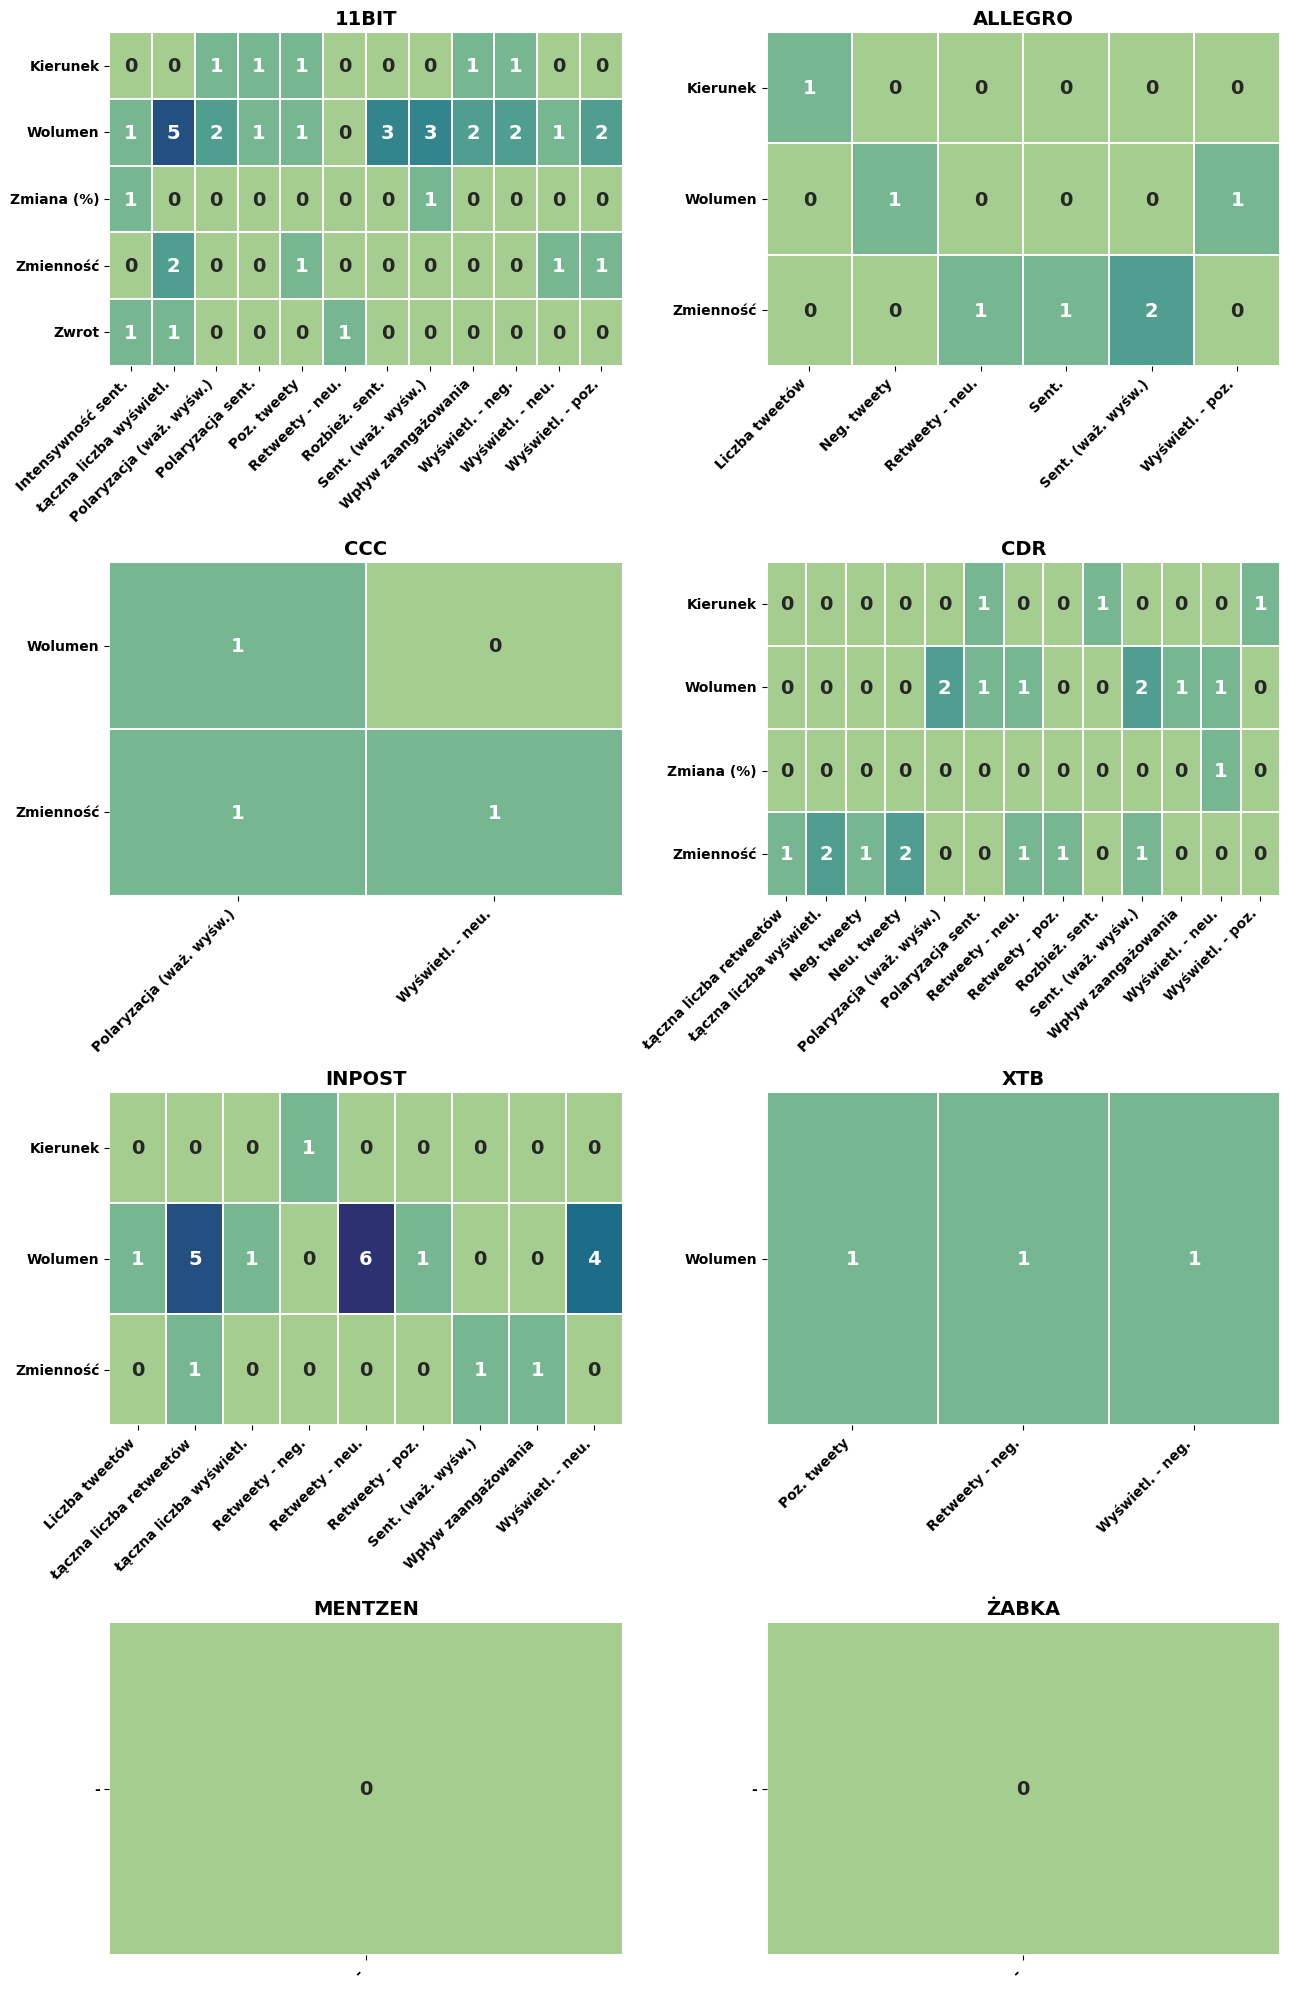

In [19]:
# Your df and column_labels_pl are assumed defined
df = granger_mlp_significant.copy()
df['Zmienne Objaśniana'] = df['stock_var'].replace(column_labels_pl)
df['Zmienne Objaśniające'] = df['twitter_var'].replace(column_labels_pl)
df['Company'] = df['company']
df['Lag'] = df['lag']
df['Significant'] = df['p_value'] <= 0.05
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
axes = axes.flatten()

max_val = 0
pivot_tables = []

for company in companies:
    # Get company data (both significant and non-significant)
    company_data = df[df['Company'] == company]
    
    # Get unique variables from company's data
    row_labels = sorted(company_data['Zmienne Objaśniana'].dropna().unique(), key=locale.strxfrm)
    col_labels = sorted(company_data['Zmienne Objaśniające'].dropna().unique(), key=locale.strxfrm)
    
    # Handle case with no variables
    if len(row_labels) == 0:
        row_labels = ["-"]
    if len(col_labels) == 0:
        col_labels = ["-"]
    
    # Create pivot table for significant relationships
    company_sig = company_data[company_data['Significant']]
    pivot_table = company_sig.pivot_table(
        index='Zmienne Objaśniana',
        columns='Zmienne Objaśniające',
        values='Lag',
        aggfunc='count',
        fill_value=0
    ).reindex(index=row_labels, columns=col_labels, fill_value=0)
    
    pivot_tables.append(pivot_table)
    
    # Update max value for color scaling
    current_max = pivot_table.max().max()
    if current_max > max_val:
        max_val = current_max

# Handle case where all values are zero
if max_val == 0:
    max_val = 1  # Prevent color scale errors

# Plot each company's heatmap
for i, company in enumerate(companies):
    ax = axes[i]
    sns.heatmap(
        pivot_tables[i],
        annot=True,
        fmt='d',
        cmap='crest',
        linewidths=0.1,
        linecolor='white',
        vmin=0,
        vmax=max_val,
        cbar=False,
        ax=ax,
        annot_kws={"fontsize": 14, "weight": "bold"}
    )
    
    ax.set_title(company, fontsize=14, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10, fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
dicc = []
for company, metdata in data.items():
    for stock_var, twitter_var in metdata['stock_vars'].items():
        for twitter_var, results in twitter_var['twitter_vars'].items():
            for stock_var, lags in results.items():
                if results.get('error',None) is not None:
                    continue
                res = {}
                for lag, res in lags.items():
                    res[lag] = {
                        'company': company,         
                        'stock_var': stock_var,
                        'twitter_var': twitter_var,
                        'p_value': res['p_value'],
                        'test_statistic': res['test_statistic'],
                        'RSS_X': res['RSS_X'],
                        'RSS_XY': res['RSS_XY']
                    }
                dicc.append(res)
                  

In [62]:
# Initialize results dictionaries
autocorrelation_results = {}
# Autocorrelation threshold
autocorr_p_threshold = 0.05  # p-value threshold for autocorrelation significance
max_lags = 10  # Maximum number of lags to test

# Check autocorrelation for each variable
for company in companies:
    STOCK = [k for k,v in stationarity_results[company]['STOCK'].items() if v]
    TWITTER = [k for k,v in stationarity_results[company]['TWITTER'].items() if v]
    autocorrelation_results[company] = {'STOCK': {}, 'TWITTER': {}}
    
    for variable in STOCK + TWITTER:
        # Extract data for the specific variable and company
        series = companies_data_daily_final_full[companies_data_daily_final_full['company'] == company][variable].dropna()
        
        # Skip if series is too short
        if len(series) <= max_lags:
            category = 'STOCK' if variable in STOCK else 'TWITTER'
            autocorrelation_results[company][category][variable] = False
            continue
        
        # Perform the Ljung-Box test for autocorrelation
        from statsmodels.stats.diagnostic import acorr_ljungbox
        result = acorr_ljungbox(series, lags=max_lags, return_df=True)
        
        # Check if any lag shows significant autocorrelation
        p_values = result['lb_pvalue']
        has_autocorrelation = any(p_values < autocorr_p_threshold)
        
        # Store whether the variable has significant autocorrelation
        category = 'STOCK' if variable in STOCK else 'TWITTER'
        autocorrelation_results[company][category][variable] = has_autocorrelation

pprint.pprint(autocorrelation_results)

{'11BIT': {'STOCK': {'Change': False,
                     'Direction': True,
                     'Return': False,
                     'Wolumen': True,
                     'volatility': True},
           'TWITTER': {'Positive': True,
                       'amplified_sentiment': False,
                       'engagement_impact': False,
                       'retweet_count_Neutral': True,
                       'sentiment_divergence': False,
                       'sentiment_intensity': True,
                       'sentiment_polarity': True,
                       'sentiment_score_views': True,
                       'total_views': True,
                       'view_count_Negative': True,
                       'view_count_Neutral': True,
                       'view_count_Positive': True,
                       'view_weighted_polarity': False}},
 'ALLEGRO': {'STOCK': {'Change': False,
                       'Direction': True,
                       'Return': False,
               